In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_CAP_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2867343, 829)
(2867343, 8)
validation
(519557, 829)
(519557, 8)
test
(237229, 829)
(237229, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1539976 (5.87 MB)


Trainable params: 1539976 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/287 [..............................] - ETA: 8:05 - loss: 2.2952 - STD: 0.0673 - MAE: 0.2207

  4/287 [..............................] - ETA: 6s - loss: 2.1339 - STD: 0.0462 - MAE: 0.2178  

  7/287 [..............................] - ETA: 6s - loss: 2.1168 - STD: 0.0563 - MAE: 0.2163

 10/287 [>.............................] - ETA: 6s - loss: 2.1020 - STD: 0.0511 - MAE: 0.2164

 13/287 [>.............................] - ETA: 6s - loss: 2.0909 - STD: 0.0458 - MAE: 0.2165

 16/287 [>.............................] - ETA: 6s - loss: 2.0844 - STD: 0.0432 - MAE: 0.2166

 19/287 [>.............................] - ETA: 6s - loss: 2.0792 - STD: 0.0415 - MAE: 0.2166

 22/287 [=>............................] - ETA: 6s - loss: 2.0744 - STD: 0.0400 - MAE: 0.2166

 25/287 [=>............................] - ETA: 6s - loss: 2.0696 - STD: 0.0393 - MAE: 0.2165

 28/287 [=>............................] - ETA: 5s - loss: 2.0652 - STD: 0.0392 - MAE: 0.2164

 31/287 [==>...........................] - ETA: 5s - loss: 2.0596 - STD: 0.0390 - MAE: 0.2162

 34/287 [==>...........................] - ETA: 5s - loss: 2.0529 - STD: 0.0387 - MAE: 0.2161

 37/287 [==>...........................] - ETA: 5s - loss: 2.0444 - STD: 0.0389 - MAE: 0.2158

 40/287 [===>..........................] - ETA: 5s - loss: 2.0341 - STD: 0.0398 - MAE: 0.2153

 43/287 [===>..........................] - ETA: 5s - loss: 2.0232 - STD: 0.0414 - MAE: 0.2148

 46/287 [===>..........................] - ETA: 5s - loss: 2.0113 - STD: 0.0433 - MAE: 0.2142

 49/287 [====>.........................] - ETA: 5s - loss: 1.9991 - STD: 0.0454 - MAE: 0.2136

 52/287 [====>.........................] - ETA: 5s - loss: 1.9863 - STD: 0.0475 - MAE: 0.2129

 55/287 [====>.........................] - ETA: 5s - loss: 1.9727 - STD: 0.0496 - MAE: 0.2122

 58/287 [=====>........................] - ETA: 5s - loss: 1.9578 - STD: 0.0517 - MAE: 0.2114

 61/287 [=====>........................] - ETA: 5s - loss: 1.9418 - STD: 0.0539 - MAE: 0.2106

 64/287 [=====>........................] - ETA: 5s - loss: 1.9250 - STD: 0.0563 - MAE: 0.2096

 67/287 [======>.......................] - ETA: 5s - loss: 1.9080 - STD: 0.0588 - MAE: 0.2087

 70/287 [======>.......................] - ETA: 4s - loss: 1.8913 - STD: 0.0613 - MAE: 0.2077

 73/287 [======>.......................] - ETA: 4s - loss: 1.8746 - STD: 0.0639 - MAE: 0.2067

 76/287 [======>.......................] - ETA: 4s - loss: 1.8583 - STD: 0.0665 - MAE: 0.2057

 79/287 [=======>......................] - ETA: 4s - loss: 1.8424 - STD: 0.0690 - MAE: 0.2047

 82/287 [=======>......................] - ETA: 4s - loss: 1.8272 - STD: 0.0714 - MAE: 0.2037

 85/287 [=======>......................] - ETA: 4s - loss: 1.8125 - STD: 0.0738 - MAE: 0.2028

 88/287 [========>.....................] - ETA: 4s - loss: 1.7983 - STD: 0.0761 - MAE: 0.2018

 91/287 [========>.....................] - ETA: 4s - loss: 1.7844 - STD: 0.0782 - MAE: 0.2009

 94/287 [========>.....................] - ETA: 4s - loss: 1.7712 - STD: 0.0803 - MAE: 0.2000

 97/287 [=========>....................] - ETA: 4s - loss: 1.7585 - STD: 0.0824 - MAE: 0.1991

100/287 [=========>....................] - ETA: 4s - loss: 1.7462 - STD: 0.0844 - MAE: 0.1982

103/287 [=========>....................] - ETA: 4s - loss: 1.7342 - STD: 0.0863 - MAE: 0.1974

106/287 [==========>...................] - ETA: 4s - loss: 1.7229 - STD: 0.0882 - MAE: 0.1966

109/287 [==========>...................] - ETA: 4s - loss: 1.7120 - STD: 0.0900 - MAE: 0.1957

112/287 [==========>...................] - ETA: 3s - loss: 1.7013 - STD: 0.0919 - MAE: 0.1949

115/287 [===========>..................] - ETA: 3s - loss: 1.6912 - STD: 0.0936 - MAE: 0.1941

118/287 [===========>..................] - ETA: 3s - loss: 1.6813 - STD: 0.0953 - MAE: 0.1934

121/287 [===========>..................] - ETA: 3s - loss: 1.6719 - STD: 0.0970 - MAE: 0.1926

124/287 [===========>..................] - ETA: 3s - loss: 1.6626 - STD: 0.0985 - MAE: 0.1919

127/287 [============>.................] - ETA: 4s - loss: 1.6547 - STD: 0.1000 - MAE: 0.1912

130/287 [============>.................] - ETA: 4s - loss: 1.6464 - STD: 0.1015 - MAE: 0.1906

133/287 [============>.................] - ETA: 4s - loss: 1.6383 - STD: 0.1029 - MAE: 0.1900

136/287 [=============>................] - ETA: 4s - loss: 1.6302 - STD: 0.1043 - MAE: 0.1893

139/287 [=============>................] - ETA: 4s - loss: 1.6227 - STD: 0.1056 - MAE: 0.1887

142/287 [=============>................] - ETA: 4s - loss: 1.6154 - STD: 0.1069 - MAE: 0.1882

145/287 [==============>...............] - ETA: 4s - loss: 1.6083 - STD: 0.1081 - MAE: 0.1876

148/287 [==============>...............] - ETA: 4s - loss: 1.6014 - STD: 0.1093 - MAE: 0.1870

151/287 [==============>...............] - ETA: 4s - loss: 1.5947 - STD: 0.1105 - MAE: 0.1865

154/287 [===============>..............] - ETA: 3s - loss: 1.5881 - STD: 0.1117 - MAE: 0.1860

157/287 [===============>..............] - ETA: 3s - loss: 1.5817 - STD: 0.1128 - MAE: 0.1854

160/287 [===============>..............] - ETA: 3s - loss: 1.5754 - STD: 0.1138 - MAE: 0.1849

163/287 [================>.............] - ETA: 3s - loss: 1.5693 - STD: 0.1149 - MAE: 0.1844

166/287 [================>.............] - ETA: 3s - loss: 1.5634 - STD: 0.1159 - MAE: 0.1839

169/287 [================>.............] - ETA: 3s - loss: 1.5577 - STD: 0.1169 - MAE: 0.1835

172/287 [================>.............] - ETA: 3s - loss: 1.5521 - STD: 0.1179 - MAE: 0.1830

175/287 [=================>............] - ETA: 3s - loss: 1.5468 - STD: 0.1188 - MAE: 0.1826

178/287 [=================>............] - ETA: 3s - loss: 1.5414 - STD: 0.1197 - MAE: 0.1821

181/287 [=================>............] - ETA: 3s - loss: 1.5364 - STD: 0.1206 - MAE: 0.1817

184/287 [==================>...........] - ETA: 2s - loss: 1.5315 - STD: 0.1215 - MAE: 0.1813

187/287 [==================>...........] - ETA: 2s - loss: 1.5267 - STD: 0.1224 - MAE: 0.1809

190/287 [==================>...........] - ETA: 2s - loss: 1.5218 - STD: 0.1232 - MAE: 0.1805

193/287 [===================>..........] - ETA: 2s - loss: 1.5172 - STD: 0.1240 - MAE: 0.1801

196/287 [===================>..........] - ETA: 2s - loss: 1.5125 - STD: 0.1248 - MAE: 0.1797

199/287 [===================>..........] - ETA: 2s - loss: 1.5080 - STD: 0.1256 - MAE: 0.1793

202/287 [====================>.........] - ETA: 2s - loss: 1.5035 - STD: 0.1263 - MAE: 0.1789

205/287 [====================>.........] - ETA: 2s - loss: 1.4992 - STD: 0.1271 - MAE: 0.1786

208/287 [====================>.........] - ETA: 2s - loss: 1.4949 - STD: 0.1278 - MAE: 0.1782

211/287 [=====================>........] - ETA: 2s - loss: 1.4908 - STD: 0.1285 - MAE: 0.1779

214/287 [=====================>........] - ETA: 2s - loss: 1.4867 - STD: 0.1292 - MAE: 0.1775

217/287 [=====================>........] - ETA: 1s - loss: 1.4828 - STD: 0.1299 - MAE: 0.1772

220/287 [=====================>........] - ETA: 1s - loss: 1.4789 - STD: 0.1306 - MAE: 0.1769

223/287 [======================>.......] - ETA: 1s - loss: 1.4751 - STD: 0.1313 - MAE: 0.1765

226/287 [======================>.......] - ETA: 1s - loss: 1.4714 - STD: 0.1319 - MAE: 0.1762

229/287 [======================>.......] - ETA: 1s - loss: 1.4676 - STD: 0.1326 - MAE: 0.1759

232/287 [=======================>......] - ETA: 1s - loss: 1.4640 - STD: 0.1332 - MAE: 0.1756

235/287 [=======================>......] - ETA: 1s - loss: 1.4606 - STD: 0.1338 - MAE: 0.1753

238/287 [=======================>......] - ETA: 1s - loss: 1.4571 - STD: 0.1344 - MAE: 0.1750

241/287 [========================>.....] - ETA: 1s - loss: 1.4538 - STD: 0.1350 - MAE: 0.1747

244/287 [========================>.....] - ETA: 1s - loss: 1.4505 - STD: 0.1355 - MAE: 0.1744

247/287 [========================>.....] - ETA: 1s - loss: 1.4473 - STD: 0.1361 - MAE: 0.1741

250/287 [=========================>....] - ETA: 0s - loss: 1.4440 - STD: 0.1367 - MAE: 0.1738

253/287 [=========================>....] - ETA: 0s - loss: 1.4406 - STD: 0.1372 - MAE: 0.1735

256/287 [=========================>....] - ETA: 0s - loss: 1.4375 - STD: 0.1378 - MAE: 0.1732

259/287 [==========================>...] - ETA: 0s - loss: 1.4343 - STD: 0.1383 - MAE: 0.1730

262/287 [==========================>...] - ETA: 0s - loss: 1.4311 - STD: 0.1389 - MAE: 0.1727

265/287 [==========================>...] - ETA: 0s - loss: 1.4281 - STD: 0.1394 - MAE: 0.1724

268/287 [===========================>..] - ETA: 0s - loss: 1.4251 - STD: 0.1399 - MAE: 0.1722

271/287 [===========================>..] - ETA: 0s - loss: 1.4222 - STD: 0.1404 - MAE: 0.1719

274/287 [===========================>..] - ETA: 0s - loss: 1.4192 - STD: 0.1409 - MAE: 0.1717

277/287 [===========================>..] - ETA: 0s - loss: 1.4163 - STD: 0.1413 - MAE: 0.1714

280/287 [============================>.] - ETA: 0s - loss: 1.4138 - STD: 0.1418 - MAE: 0.1712

283/287 [============================>.] - ETA: 0s - loss: 1.4110 - STD: 0.1423 - MAE: 0.1709

286/287 [============================>.] - ETA: 0s - loss: 1.4083 - STD: 0.1428 - MAE: 0.1707

287/287 [==============================] - 11s 32ms/step - loss: 1.4074 - STD: 0.1429 - MAE: 0.1706 - val_loss: 1.2368 - val_STD: 0.1809 - val_MAE: 0.1542


Epoch 2/10000


  1/287 [..............................] - ETA: 11s - loss: 1.1594 - STD: 0.1862 - MAE: 0.1481

  4/287 [..............................] - ETA: 6s - loss: 1.1448 - STD: 0.1864 - MAE: 0.1474 

  7/287 [..............................] - ETA: 6s - loss: 1.1451 - STD: 0.1870 - MAE: 0.1471

 10/287 [>.............................] - ETA: 6s - loss: 1.1431 - STD: 0.1875 - MAE: 0.1469

 13/287 [>.............................] - ETA: 6s - loss: 1.1425 - STD: 0.1877 - MAE: 0.1468

 16/287 [>.............................] - ETA: 6s - loss: 1.1412 - STD: 0.1877 - MAE: 0.1468

 19/287 [>.............................] - ETA: 6s - loss: 1.1392 - STD: 0.1878 - MAE: 0.1466

 22/287 [=>............................] - ETA: 6s - loss: 1.1383 - STD: 0.1881 - MAE: 0.1465

 25/287 [=>............................] - ETA: 5s - loss: 1.1368 - STD: 0.1882 - MAE: 0.1464

 28/287 [=>............................] - ETA: 5s - loss: 1.1366 - STD: 0.1884 - MAE: 0.1463

 31/287 [==>...........................] - ETA: 5s - loss: 1.1355 - STD: 0.1886 - MAE: 0.1462

 34/287 [==>...........................] - ETA: 5s - loss: 1.1351 - STD: 0.1887 - MAE: 0.1462

 37/287 [==>...........................] - ETA: 5s - loss: 1.1345 - STD: 0.1887 - MAE: 0.1461

 40/287 [===>..........................] - ETA: 5s - loss: 1.1333 - STD: 0.1888 - MAE: 0.1460

 43/287 [===>..........................] - ETA: 5s - loss: 1.1338 - STD: 0.1891 - MAE: 0.1459

 46/287 [===>..........................] - ETA: 5s - loss: 1.1336 - STD: 0.1892 - MAE: 0.1459

 49/287 [====>.........................] - ETA: 5s - loss: 1.1340 - STD: 0.1893 - MAE: 0.1459

 52/287 [====>.........................] - ETA: 5s - loss: 1.1330 - STD: 0.1893 - MAE: 0.1458

 55/287 [====>.........................] - ETA: 5s - loss: 1.1324 - STD: 0.1895 - MAE: 0.1457

 58/287 [=====>........................] - ETA: 5s - loss: 1.1318 - STD: 0.1896 - MAE: 0.1457

 61/287 [=====>........................] - ETA: 5s - loss: 1.1315 - STD: 0.1896 - MAE: 0.1456

 64/287 [=====>........................] - ETA: 5s - loss: 1.1309 - STD: 0.1897 - MAE: 0.1456

 67/287 [======>.......................] - ETA: 5s - loss: 1.1303 - STD: 0.1898 - MAE: 0.1455

 70/287 [======>.......................] - ETA: 4s - loss: 1.1296 - STD: 0.1900 - MAE: 0.1454

 73/287 [======>.......................] - ETA: 4s - loss: 1.1292 - STD: 0.1900 - MAE: 0.1454

 76/287 [======>.......................] - ETA: 4s - loss: 1.1286 - STD: 0.1901 - MAE: 0.1453

 79/287 [=======>......................] - ETA: 4s - loss: 1.1285 - STD: 0.1901 - MAE: 0.1453

 82/287 [=======>......................] - ETA: 4s - loss: 1.1278 - STD: 0.1902 - MAE: 0.1453

 85/287 [=======>......................] - ETA: 4s - loss: 1.1274 - STD: 0.1902 - MAE: 0.1452

 88/287 [========>.....................] - ETA: 4s - loss: 1.1265 - STD: 0.1904 - MAE: 0.1451

 91/287 [========>.....................] - ETA: 4s - loss: 1.1258 - STD: 0.1905 - MAE: 0.1450

 94/287 [========>.....................] - ETA: 4s - loss: 1.1253 - STD: 0.1905 - MAE: 0.1450

 97/287 [=========>....................] - ETA: 4s - loss: 1.1249 - STD: 0.1906 - MAE: 0.1449

100/287 [=========>....................] - ETA: 4s - loss: 1.1242 - STD: 0.1907 - MAE: 0.1449

103/287 [=========>....................] - ETA: 4s - loss: 1.1233 - STD: 0.1908 - MAE: 0.1448

106/287 [==========>...................] - ETA: 4s - loss: 1.1226 - STD: 0.1909 - MAE: 0.1447

109/287 [==========>...................] - ETA: 4s - loss: 1.1215 - STD: 0.1910 - MAE: 0.1446

112/287 [==========>...................] - ETA: 3s - loss: 1.1207 - STD: 0.1911 - MAE: 0.1445

115/287 [===========>..................] - ETA: 3s - loss: 1.1204 - STD: 0.1912 - MAE: 0.1445

118/287 [===========>..................] - ETA: 3s - loss: 1.1203 - STD: 0.1913 - MAE: 0.1444

121/287 [===========>..................] - ETA: 3s - loss: 1.1199 - STD: 0.1915 - MAE: 0.1444

124/287 [===========>..................] - ETA: 3s - loss: 1.1195 - STD: 0.1915 - MAE: 0.1443

127/287 [============>.................] - ETA: 3s - loss: 1.1189 - STD: 0.1916 - MAE: 0.1443

130/287 [============>.................] - ETA: 3s - loss: 1.1183 - STD: 0.1917 - MAE: 0.1442

133/287 [============>.................] - ETA: 3s - loss: 1.1175 - STD: 0.1917 - MAE: 0.1442

136/287 [=============>................] - ETA: 3s - loss: 1.1171 - STD: 0.1918 - MAE: 0.1441

139/287 [=============>................] - ETA: 3s - loss: 1.1166 - STD: 0.1919 - MAE: 0.1440

142/287 [=============>................] - ETA: 3s - loss: 1.1160 - STD: 0.1920 - MAE: 0.1440

145/287 [==============>...............] - ETA: 3s - loss: 1.1156 - STD: 0.1920 - MAE: 0.1439

148/287 [==============>...............] - ETA: 3s - loss: 1.1153 - STD: 0.1921 - MAE: 0.1439

151/287 [==============>...............] - ETA: 3s - loss: 1.1149 - STD: 0.1922 - MAE: 0.1439

154/287 [===============>..............] - ETA: 3s - loss: 1.1144 - STD: 0.1922 - MAE: 0.1438

157/287 [===============>..............] - ETA: 2s - loss: 1.1139 - STD: 0.1923 - MAE: 0.1438

160/287 [===============>..............] - ETA: 2s - loss: 1.1133 - STD: 0.1924 - MAE: 0.1437

163/287 [================>.............] - ETA: 2s - loss: 1.1128 - STD: 0.1925 - MAE: 0.1436

166/287 [================>.............] - ETA: 2s - loss: 1.1123 - STD: 0.1925 - MAE: 0.1436

169/287 [================>.............] - ETA: 2s - loss: 1.1118 - STD: 0.1926 - MAE: 0.1435

172/287 [================>.............] - ETA: 2s - loss: 1.1113 - STD: 0.1927 - MAE: 0.1435

175/287 [=================>............] - ETA: 2s - loss: 1.1110 - STD: 0.1927 - MAE: 0.1435

178/287 [=================>............] - ETA: 2s - loss: 1.1104 - STD: 0.1928 - MAE: 0.1434

181/287 [=================>............] - ETA: 2s - loss: 1.1100 - STD: 0.1929 - MAE: 0.1433

184/287 [==================>...........] - ETA: 2s - loss: 1.1094 - STD: 0.1930 - MAE: 0.1433

187/287 [==================>...........] - ETA: 2s - loss: 1.1090 - STD: 0.1930 - MAE: 0.1432

190/287 [==================>...........] - ETA: 2s - loss: 1.1085 - STD: 0.1931 - MAE: 0.1432

193/287 [===================>..........] - ETA: 2s - loss: 1.1080 - STD: 0.1932 - MAE: 0.1431

196/287 [===================>..........] - ETA: 2s - loss: 1.1074 - STD: 0.1932 - MAE: 0.1431

199/287 [===================>..........] - ETA: 2s - loss: 1.1068 - STD: 0.1933 - MAE: 0.1430

202/287 [====================>.........] - ETA: 1s - loss: 1.1063 - STD: 0.1934 - MAE: 0.1430

205/287 [====================>.........] - ETA: 1s - loss: 1.1057 - STD: 0.1934 - MAE: 0.1429

208/287 [====================>.........] - ETA: 1s - loss: 1.1051 - STD: 0.1935 - MAE: 0.1428

211/287 [=====================>........] - ETA: 1s - loss: 1.1042 - STD: 0.1936 - MAE: 0.1428

214/287 [=====================>........] - ETA: 1s - loss: 1.1037 - STD: 0.1937 - MAE: 0.1427

217/287 [=====================>........] - ETA: 1s - loss: 1.1031 - STD: 0.1938 - MAE: 0.1426

219/287 [=====================>........] - ETA: 1s - loss: 1.1028 - STD: 0.1938 - MAE: 0.1426

222/287 [======================>.......] - ETA: 1s - loss: 1.1023 - STD: 0.1939 - MAE: 0.1425

225/287 [======================>.......] - ETA: 1s - loss: 1.1019 - STD: 0.1940 - MAE: 0.1425

228/287 [======================>.......] - ETA: 1s - loss: 1.1014 - STD: 0.1940 - MAE: 0.1424

231/287 [=======================>......] - ETA: 1s - loss: 1.1009 - STD: 0.1941 - MAE: 0.1424

234/287 [=======================>......] - ETA: 1s - loss: 1.1005 - STD: 0.1942 - MAE: 0.1423

237/287 [=======================>......] - ETA: 1s - loss: 1.0999 - STD: 0.1943 - MAE: 0.1423

240/287 [========================>.....] - ETA: 1s - loss: 1.0993 - STD: 0.1943 - MAE: 0.1422

243/287 [========================>.....] - ETA: 1s - loss: 1.0988 - STD: 0.1944 - MAE: 0.1422

246/287 [========================>.....] - ETA: 0s - loss: 1.0983 - STD: 0.1944 - MAE: 0.1421

249/287 [=========================>....] - ETA: 0s - loss: 1.0979 - STD: 0.1945 - MAE: 0.1421

252/287 [=========================>....] - ETA: 0s - loss: 1.0975 - STD: 0.1946 - MAE: 0.1420

255/287 [=========================>....] - ETA: 0s - loss: 1.0971 - STD: 0.1946 - MAE: 0.1420

258/287 [=========================>....] - ETA: 0s - loss: 1.0964 - STD: 0.1947 - MAE: 0.1419

261/287 [==========================>...] - ETA: 0s - loss: 1.0961 - STD: 0.1948 - MAE: 0.1419

264/287 [==========================>...] - ETA: 0s - loss: 1.0956 - STD: 0.1949 - MAE: 0.1418

267/287 [==========================>...] - ETA: 0s - loss: 1.0951 - STD: 0.1949 - MAE: 0.1418

270/287 [===========================>..] - ETA: 0s - loss: 1.0947 - STD: 0.1950 - MAE: 0.1417

273/287 [===========================>..] - ETA: 0s - loss: 1.0942 - STD: 0.1950 - MAE: 0.1417

276/287 [===========================>..] - ETA: 0s - loss: 1.0937 - STD: 0.1951 - MAE: 0.1416

279/287 [============================>.] - ETA: 0s - loss: 1.0934 - STD: 0.1952 - MAE: 0.1416

282/287 [============================>.] - ETA: 0s - loss: 1.0929 - STD: 0.1952 - MAE: 0.1415

285/287 [============================>.] - ETA: 0s - loss: 1.0924 - STD: 0.1953 - MAE: 0.1415

287/287 [==============================] - 7s 26ms/step - loss: 1.0922 - STD: 0.1953 - MAE: 0.1415 - val_loss: 1.1390 - val_STD: 0.1982 - val_MAE: 0.1430


Epoch 3/10000


  1/287 [..............................] - ETA: 14s - loss: 1.0748 - STD: 0.2025 - MAE: 0.1371

  4/287 [..............................] - ETA: 6s - loss: 1.0556 - STD: 0.2020 - MAE: 0.1368 

  7/287 [..............................] - ETA: 6s - loss: 1.0533 - STD: 0.2019 - MAE: 0.1367

 10/287 [>.............................] - ETA: 6s - loss: 1.0516 - STD: 0.2017 - MAE: 0.1367

 13/287 [>.............................] - ETA: 6s - loss: 1.0502 - STD: 0.2015 - MAE: 0.1368

 16/287 [>.............................] - ETA: 6s - loss: 1.0478 - STD: 0.2015 - MAE: 0.1366

 19/287 [>.............................] - ETA: 6s - loss: 1.0482 - STD: 0.2015 - MAE: 0.1366

 22/287 [=>............................] - ETA: 6s - loss: 1.0463 - STD: 0.2015 - MAE: 0.1365

 25/287 [=>............................] - ETA: 5s - loss: 1.0456 - STD: 0.2016 - MAE: 0.1365

 28/287 [=>............................] - ETA: 5s - loss: 1.0448 - STD: 0.2017 - MAE: 0.1364

 31/287 [==>...........................] - ETA: 5s - loss: 1.0457 - STD: 0.2017 - MAE: 0.1364

 34/287 [==>...........................] - ETA: 5s - loss: 1.0456 - STD: 0.2018 - MAE: 0.1364

 37/287 [==>...........................] - ETA: 5s - loss: 1.0465 - STD: 0.2019 - MAE: 0.1364

 40/287 [===>..........................] - ETA: 5s - loss: 1.0469 - STD: 0.2020 - MAE: 0.1364

 43/287 [===>..........................] - ETA: 5s - loss: 1.0474 - STD: 0.2021 - MAE: 0.1364

 46/287 [===>..........................] - ETA: 5s - loss: 1.0488 - STD: 0.2021 - MAE: 0.1365

 49/287 [====>.........................] - ETA: 5s - loss: 1.0490 - STD: 0.2021 - MAE: 0.1365

 52/287 [====>.........................] - ETA: 5s - loss: 1.0491 - STD: 0.2021 - MAE: 0.1365

 55/287 [====>.........................] - ETA: 5s - loss: 1.0490 - STD: 0.2021 - MAE: 0.1364

 58/287 [=====>........................] - ETA: 5s - loss: 1.0483 - STD: 0.2021 - MAE: 0.1364

 61/287 [=====>........................] - ETA: 5s - loss: 1.0477 - STD: 0.2022 - MAE: 0.1363

 64/287 [=====>........................] - ETA: 5s - loss: 1.0473 - STD: 0.2022 - MAE: 0.1363

 67/287 [======>.......................] - ETA: 5s - loss: 1.0463 - STD: 0.2022 - MAE: 0.1363

 70/287 [======>.......................] - ETA: 4s - loss: 1.0459 - STD: 0.2022 - MAE: 0.1362

 73/287 [======>.......................] - ETA: 4s - loss: 1.0450 - STD: 0.2023 - MAE: 0.1362

 76/287 [======>.......................] - ETA: 4s - loss: 1.0442 - STD: 0.2023 - MAE: 0.1361

 79/287 [=======>......................] - ETA: 4s - loss: 1.0439 - STD: 0.2023 - MAE: 0.1361

 82/287 [=======>......................] - ETA: 4s - loss: 1.0432 - STD: 0.2023 - MAE: 0.1360

 85/287 [=======>......................] - ETA: 4s - loss: 1.0425 - STD: 0.2024 - MAE: 0.1359

 88/287 [========>.....................] - ETA: 4s - loss: 1.0428 - STD: 0.2025 - MAE: 0.1359

 91/287 [========>.....................] - ETA: 4s - loss: 1.0422 - STD: 0.2025 - MAE: 0.1359

 94/287 [========>.....................] - ETA: 4s - loss: 1.0422 - STD: 0.2026 - MAE: 0.1358

 97/287 [=========>....................] - ETA: 4s - loss: 1.0419 - STD: 0.2026 - MAE: 0.1358

100/287 [=========>....................] - ETA: 4s - loss: 1.0414 - STD: 0.2026 - MAE: 0.1358

103/287 [=========>....................] - ETA: 4s - loss: 1.0407 - STD: 0.2027 - MAE: 0.1357

106/287 [==========>...................] - ETA: 4s - loss: 1.0400 - STD: 0.2027 - MAE: 0.1357

109/287 [==========>...................] - ETA: 4s - loss: 1.0394 - STD: 0.2028 - MAE: 0.1356

112/287 [==========>...................] - ETA: 3s - loss: 1.0390 - STD: 0.2028 - MAE: 0.1356

115/287 [===========>..................] - ETA: 3s - loss: 1.0387 - STD: 0.2029 - MAE: 0.1355

118/287 [===========>..................] - ETA: 3s - loss: 1.0381 - STD: 0.2030 - MAE: 0.1355

121/287 [===========>..................] - ETA: 3s - loss: 1.0377 - STD: 0.2030 - MAE: 0.1354

124/287 [===========>..................] - ETA: 3s - loss: 1.0372 - STD: 0.2030 - MAE: 0.1354

127/287 [============>.................] - ETA: 3s - loss: 1.0368 - STD: 0.2031 - MAE: 0.1353

130/287 [============>.................] - ETA: 3s - loss: 1.0365 - STD: 0.2032 - MAE: 0.1353

133/287 [============>.................] - ETA: 3s - loss: 1.0364 - STD: 0.2032 - MAE: 0.1352

136/287 [=============>................] - ETA: 3s - loss: 1.0363 - STD: 0.2033 - MAE: 0.1352

139/287 [=============>................] - ETA: 3s - loss: 1.0361 - STD: 0.2033 - MAE: 0.1352

142/287 [=============>................] - ETA: 3s - loss: 1.0356 - STD: 0.2033 - MAE: 0.1351

145/287 [==============>...............] - ETA: 3s - loss: 1.0351 - STD: 0.2034 - MAE: 0.1351

148/287 [==============>...............] - ETA: 3s - loss: 1.0345 - STD: 0.2035 - MAE: 0.1350

151/287 [==============>...............] - ETA: 3s - loss: 1.0341 - STD: 0.2035 - MAE: 0.1350

154/287 [===============>..............] - ETA: 3s - loss: 1.0335 - STD: 0.2036 - MAE: 0.1349

157/287 [===============>..............] - ETA: 2s - loss: 1.0329 - STD: 0.2036 - MAE: 0.1349

160/287 [===============>..............] - ETA: 2s - loss: 1.0323 - STD: 0.2037 - MAE: 0.1348

163/287 [================>.............] - ETA: 2s - loss: 1.0319 - STD: 0.2037 - MAE: 0.1348

166/287 [================>.............] - ETA: 2s - loss: 1.0315 - STD: 0.2038 - MAE: 0.1347

169/287 [================>.............] - ETA: 2s - loss: 1.0310 - STD: 0.2038 - MAE: 0.1347

172/287 [================>.............] - ETA: 2s - loss: 1.0306 - STD: 0.2039 - MAE: 0.1346

175/287 [=================>............] - ETA: 2s - loss: 1.0301 - STD: 0.2039 - MAE: 0.1346

178/287 [=================>............] - ETA: 2s - loss: 1.0296 - STD: 0.2040 - MAE: 0.1345

181/287 [=================>............] - ETA: 2s - loss: 1.0294 - STD: 0.2041 - MAE: 0.1345

184/287 [==================>...........] - ETA: 2s - loss: 1.0290 - STD: 0.2041 - MAE: 0.1344

187/287 [==================>...........] - ETA: 2s - loss: 1.0287 - STD: 0.2042 - MAE: 0.1344

190/287 [==================>...........] - ETA: 2s - loss: 1.0284 - STD: 0.2042 - MAE: 0.1343

193/287 [===================>..........] - ETA: 2s - loss: 1.0279 - STD: 0.2043 - MAE: 0.1343

196/287 [===================>..........] - ETA: 2s - loss: 1.0274 - STD: 0.2044 - MAE: 0.1342

199/287 [===================>..........] - ETA: 2s - loss: 1.0269 - STD: 0.2044 - MAE: 0.1342

202/287 [====================>.........] - ETA: 1s - loss: 1.0265 - STD: 0.2044 - MAE: 0.1341

205/287 [====================>.........] - ETA: 1s - loss: 1.0260 - STD: 0.2045 - MAE: 0.1341

208/287 [====================>.........] - ETA: 1s - loss: 1.0257 - STD: 0.2046 - MAE: 0.1340

211/287 [=====================>........] - ETA: 1s - loss: 1.0255 - STD: 0.2046 - MAE: 0.1340

214/287 [=====================>........] - ETA: 1s - loss: 1.0249 - STD: 0.2046 - MAE: 0.1340

217/287 [=====================>........] - ETA: 1s - loss: 1.0245 - STD: 0.2047 - MAE: 0.1339

220/287 [=====================>........] - ETA: 1s - loss: 1.0240 - STD: 0.2048 - MAE: 0.1339

222/287 [======================>.......] - ETA: 1s - loss: 1.0239 - STD: 0.2048 - MAE: 0.1338

225/287 [======================>.......] - ETA: 1s - loss: 1.0235 - STD: 0.2048 - MAE: 0.1338

228/287 [======================>.......] - ETA: 1s - loss: 1.0231 - STD: 0.2049 - MAE: 0.1338

231/287 [=======================>......] - ETA: 1s - loss: 1.0226 - STD: 0.2049 - MAE: 0.1337

234/287 [=======================>......] - ETA: 1s - loss: 1.0222 - STD: 0.2050 - MAE: 0.1337

237/287 [=======================>......] - ETA: 1s - loss: 1.0221 - STD: 0.2050 - MAE: 0.1336

240/287 [========================>.....] - ETA: 1s - loss: 1.0219 - STD: 0.2051 - MAE: 0.1336

243/287 [========================>.....] - ETA: 1s - loss: 1.0216 - STD: 0.2052 - MAE: 0.1335

246/287 [========================>.....] - ETA: 0s - loss: 1.0211 - STD: 0.2052 - MAE: 0.1335

249/287 [=========================>....] - ETA: 0s - loss: 1.0206 - STD: 0.2053 - MAE: 0.1335

252/287 [=========================>....] - ETA: 0s - loss: 1.0203 - STD: 0.2053 - MAE: 0.1334

255/287 [=========================>....] - ETA: 0s - loss: 1.0197 - STD: 0.2054 - MAE: 0.1334

258/287 [=========================>....] - ETA: 0s - loss: 1.0194 - STD: 0.2054 - MAE: 0.1333

261/287 [==========================>...] - ETA: 0s - loss: 1.0190 - STD: 0.2055 - MAE: 0.1333

264/287 [==========================>...] - ETA: 0s - loss: 1.0187 - STD: 0.2055 - MAE: 0.1332

267/287 [==========================>...] - ETA: 0s - loss: 1.0184 - STD: 0.2056 - MAE: 0.1332

270/287 [===========================>..] - ETA: 0s - loss: 1.0182 - STD: 0.2057 - MAE: 0.1331

273/287 [===========================>..] - ETA: 0s - loss: 1.0179 - STD: 0.2057 - MAE: 0.1331

276/287 [===========================>..] - ETA: 0s - loss: 1.0175 - STD: 0.2058 - MAE: 0.1331

279/287 [============================>.] - ETA: 0s - loss: 1.0174 - STD: 0.2058 - MAE: 0.1330

282/287 [============================>.] - ETA: 0s - loss: 1.0173 - STD: 0.2059 - MAE: 0.1330

285/287 [============================>.] - ETA: 0s - loss: 1.0173 - STD: 0.2059 - MAE: 0.1330

287/287 [==============================] - 7s 26ms/step - loss: 1.0172 - STD: 0.2059 - MAE: 0.1330 - val_loss: 1.1106 - val_STD: 0.2055 - val_MAE: 0.1388


Epoch 4/10000


  1/287 [..............................] - ETA: 13s - loss: 0.9939 - STD: 0.2097 - MAE: 0.1303

  4/287 [..............................] - ETA: 6s - loss: 0.9934 - STD: 0.2095 - MAE: 0.1300 

  7/287 [..............................] - ETA: 6s - loss: 0.9887 - STD: 0.2096 - MAE: 0.1297

 10/287 [>.............................] - ETA: 6s - loss: 0.9875 - STD: 0.2095 - MAE: 0.1296

 13/287 [>.............................] - ETA: 6s - loss: 0.9858 - STD: 0.2095 - MAE: 0.1295

 16/287 [>.............................] - ETA: 6s - loss: 0.9853 - STD: 0.2094 - MAE: 0.1295

 19/287 [>.............................] - ETA: 6s - loss: 0.9842 - STD: 0.2097 - MAE: 0.1294

 22/287 [=>............................] - ETA: 5s - loss: 0.9831 - STD: 0.2098 - MAE: 0.1293

 25/287 [=>............................] - ETA: 5s - loss: 0.9816 - STD: 0.2099 - MAE: 0.1291

 28/287 [=>............................] - ETA: 5s - loss: 0.9814 - STD: 0.2101 - MAE: 0.1291

 31/287 [==>...........................] - ETA: 5s - loss: 0.9812 - STD: 0.2102 - MAE: 0.1290

 34/287 [==>...........................] - ETA: 5s - loss: 0.9819 - STD: 0.2102 - MAE: 0.1291

 37/287 [==>...........................] - ETA: 5s - loss: 0.9818 - STD: 0.2104 - MAE: 0.1290

 40/287 [===>..........................] - ETA: 5s - loss: 0.9814 - STD: 0.2105 - MAE: 0.1289

 43/287 [===>..........................] - ETA: 5s - loss: 0.9815 - STD: 0.2105 - MAE: 0.1289

 46/287 [===>..........................] - ETA: 5s - loss: 0.9813 - STD: 0.2106 - MAE: 0.1288

 49/287 [====>.........................] - ETA: 5s - loss: 0.9807 - STD: 0.2107 - MAE: 0.1288

 52/287 [====>.........................] - ETA: 5s - loss: 0.9805 - STD: 0.2108 - MAE: 0.1287

 55/287 [====>.........................] - ETA: 5s - loss: 0.9807 - STD: 0.2109 - MAE: 0.1287

 58/287 [=====>........................] - ETA: 5s - loss: 0.9802 - STD: 0.2109 - MAE: 0.1287

 61/287 [=====>........................] - ETA: 5s - loss: 0.9803 - STD: 0.2109 - MAE: 0.1287

 64/287 [=====>........................] - ETA: 5s - loss: 0.9795 - STD: 0.2109 - MAE: 0.1286

 66/287 [=====>........................] - ETA: 5s - loss: 0.9787 - STD: 0.2110 - MAE: 0.1286

 69/287 [======>.......................] - ETA: 4s - loss: 0.9779 - STD: 0.2110 - MAE: 0.1285

 72/287 [======>.......................] - ETA: 4s - loss: 0.9774 - STD: 0.2111 - MAE: 0.1284

 75/287 [======>.......................] - ETA: 4s - loss: 0.9769 - STD: 0.2111 - MAE: 0.1284

 78/287 [=======>......................] - ETA: 4s - loss: 0.9760 - STD: 0.2112 - MAE: 0.1283

 81/287 [=======>......................] - ETA: 4s - loss: 0.9755 - STD: 0.2113 - MAE: 0.1282

 84/287 [=======>......................] - ETA: 4s - loss: 0.9751 - STD: 0.2113 - MAE: 0.1282

 87/287 [========>.....................] - ETA: 4s - loss: 0.9745 - STD: 0.2113 - MAE: 0.1282

 90/287 [========>.....................] - ETA: 4s - loss: 0.9743 - STD: 0.2114 - MAE: 0.1281

 93/287 [========>.....................] - ETA: 4s - loss: 0.9740 - STD: 0.2115 - MAE: 0.1281

 96/287 [=========>....................] - ETA: 4s - loss: 0.9735 - STD: 0.2115 - MAE: 0.1280

 99/287 [=========>....................] - ETA: 4s - loss: 0.9733 - STD: 0.2116 - MAE: 0.1280

102/287 [=========>....................] - ETA: 4s - loss: 0.9732 - STD: 0.2116 - MAE: 0.1280

105/287 [=========>....................] - ETA: 4s - loss: 0.9729 - STD: 0.2117 - MAE: 0.1279

108/287 [==========>...................] - ETA: 4s - loss: 0.9725 - STD: 0.2117 - MAE: 0.1279

111/287 [==========>...................] - ETA: 3s - loss: 0.9721 - STD: 0.2118 - MAE: 0.1278

114/287 [==========>...................] - ETA: 3s - loss: 0.9717 - STD: 0.2118 - MAE: 0.1278

117/287 [===========>..................] - ETA: 3s - loss: 0.9722 - STD: 0.2119 - MAE: 0.1278

120/287 [===========>..................] - ETA: 3s - loss: 0.9721 - STD: 0.2119 - MAE: 0.1278

123/287 [===========>..................] - ETA: 3s - loss: 0.9720 - STD: 0.2120 - MAE: 0.1278

126/287 [============>.................] - ETA: 3s - loss: 0.9720 - STD: 0.2120 - MAE: 0.1278

129/287 [============>.................] - ETA: 3s - loss: 0.9720 - STD: 0.2121 - MAE: 0.1277

132/287 [============>.................] - ETA: 3s - loss: 0.9721 - STD: 0.2121 - MAE: 0.1277

135/287 [=============>................] - ETA: 3s - loss: 0.9718 - STD: 0.2121 - MAE: 0.1277

138/287 [=============>................] - ETA: 3s - loss: 0.9716 - STD: 0.2121 - MAE: 0.1277

141/287 [=============>................] - ETA: 3s - loss: 0.9712 - STD: 0.2122 - MAE: 0.1276

144/287 [==============>...............] - ETA: 3s - loss: 0.9710 - STD: 0.2122 - MAE: 0.1276

147/287 [==============>...............] - ETA: 3s - loss: 0.9705 - STD: 0.2122 - MAE: 0.1276

150/287 [==============>...............] - ETA: 3s - loss: 0.9701 - STD: 0.2123 - MAE: 0.1275

153/287 [==============>...............] - ETA: 3s - loss: 0.9700 - STD: 0.2123 - MAE: 0.1275

156/287 [===============>..............] - ETA: 2s - loss: 0.9698 - STD: 0.2123 - MAE: 0.1275

159/287 [===============>..............] - ETA: 2s - loss: 0.9694 - STD: 0.2124 - MAE: 0.1274

162/287 [===============>..............] - ETA: 2s - loss: 0.9691 - STD: 0.2124 - MAE: 0.1274

165/287 [================>.............] - ETA: 2s - loss: 0.9690 - STD: 0.2124 - MAE: 0.1274

168/287 [================>.............] - ETA: 2s - loss: 0.9689 - STD: 0.2125 - MAE: 0.1274

171/287 [================>.............] - ETA: 2s - loss: 0.9690 - STD: 0.2125 - MAE: 0.1274

174/287 [=================>............] - ETA: 2s - loss: 0.9689 - STD: 0.2126 - MAE: 0.1273

177/287 [=================>............] - ETA: 2s - loss: 0.9688 - STD: 0.2126 - MAE: 0.1273

180/287 [=================>............] - ETA: 2s - loss: 0.9685 - STD: 0.2126 - MAE: 0.1273

183/287 [==================>...........] - ETA: 2s - loss: 0.9682 - STD: 0.2127 - MAE: 0.1273

186/287 [==================>...........] - ETA: 2s - loss: 0.9679 - STD: 0.2127 - MAE: 0.1272

189/287 [==================>...........] - ETA: 2s - loss: 0.9675 - STD: 0.2127 - MAE: 0.1272

192/287 [===================>..........] - ETA: 2s - loss: 0.9674 - STD: 0.2128 - MAE: 0.1272

195/287 [===================>..........] - ETA: 2s - loss: 0.9672 - STD: 0.2128 - MAE: 0.1271

198/287 [===================>..........] - ETA: 2s - loss: 0.9670 - STD: 0.2128 - MAE: 0.1271

201/287 [====================>.........] - ETA: 1s - loss: 0.9667 - STD: 0.2128 - MAE: 0.1271

204/287 [====================>.........] - ETA: 1s - loss: 0.9663 - STD: 0.2129 - MAE: 0.1271

207/287 [====================>.........] - ETA: 1s - loss: 0.9660 - STD: 0.2129 - MAE: 0.1270

210/287 [====================>.........] - ETA: 1s - loss: 0.9659 - STD: 0.2129 - MAE: 0.1270

213/287 [=====================>........] - ETA: 1s - loss: 0.9657 - STD: 0.2130 - MAE: 0.1270

216/287 [=====================>........] - ETA: 1s - loss: 0.9653 - STD: 0.2130 - MAE: 0.1269

219/287 [=====================>........] - ETA: 1s - loss: 0.9651 - STD: 0.2131 - MAE: 0.1269

222/287 [======================>.......] - ETA: 1s - loss: 0.9649 - STD: 0.2131 - MAE: 0.1269

225/287 [======================>.......] - ETA: 1s - loss: 0.9646 - STD: 0.2131 - MAE: 0.1268

228/287 [======================>.......] - ETA: 1s - loss: 0.9644 - STD: 0.2132 - MAE: 0.1268

231/287 [=======================>......] - ETA: 1s - loss: 0.9642 - STD: 0.2132 - MAE: 0.1268

234/287 [=======================>......] - ETA: 1s - loss: 0.9640 - STD: 0.2133 - MAE: 0.1267

237/287 [=======================>......] - ETA: 1s - loss: 0.9637 - STD: 0.2133 - MAE: 0.1267

240/287 [========================>.....] - ETA: 1s - loss: 0.9637 - STD: 0.2133 - MAE: 0.1267

243/287 [========================>.....] - ETA: 1s - loss: 0.9637 - STD: 0.2134 - MAE: 0.1267

246/287 [========================>.....] - ETA: 0s - loss: 0.9636 - STD: 0.2134 - MAE: 0.1267

249/287 [=========================>....] - ETA: 0s - loss: 0.9634 - STD: 0.2134 - MAE: 0.1266

252/287 [=========================>....] - ETA: 0s - loss: 0.9631 - STD: 0.2134 - MAE: 0.1266

255/287 [=========================>....] - ETA: 0s - loss: 0.9629 - STD: 0.2135 - MAE: 0.1266

258/287 [=========================>....] - ETA: 0s - loss: 0.9627 - STD: 0.2135 - MAE: 0.1266

261/287 [==========================>...] - ETA: 0s - loss: 0.9626 - STD: 0.2135 - MAE: 0.1265

264/287 [==========================>...] - ETA: 0s - loss: 0.9624 - STD: 0.2136 - MAE: 0.1265

267/287 [==========================>...] - ETA: 0s - loss: 0.9623 - STD: 0.2136 - MAE: 0.1265

270/287 [===========================>..] - ETA: 0s - loss: 0.9619 - STD: 0.2136 - MAE: 0.1265

273/287 [===========================>..] - ETA: 0s - loss: 0.9616 - STD: 0.2137 - MAE: 0.1264

276/287 [===========================>..] - ETA: 0s - loss: 0.9614 - STD: 0.2137 - MAE: 0.1264

279/287 [============================>.] - ETA: 0s - loss: 0.9613 - STD: 0.2137 - MAE: 0.1264

281/287 [============================>.] - ETA: 0s - loss: 0.9612 - STD: 0.2137 - MAE: 0.1264

284/287 [============================>.] - ETA: 0s - loss: 0.9611 - STD: 0.2138 - MAE: 0.1263

287/287 [==============================] - ETA: 0s - loss: 0.9609 - STD: 0.2138 - MAE: 0.1263

287/287 [==============================] - 7s 26ms/step - loss: 0.9609 - STD: 0.2138 - MAE: 0.1263 - val_loss: 1.1374 - val_STD: 0.2136 - val_MAE: 0.1371


Epoch 5/10000


  1/287 [..............................] - ETA: 12s - loss: 0.9210 - STD: 0.2185 - MAE: 0.1218

  4/287 [..............................] - ETA: 6s - loss: 0.9275 - STD: 0.2172 - MAE: 0.1229 

  7/287 [..............................] - ETA: 6s - loss: 0.9308 - STD: 0.2173 - MAE: 0.1231

 10/287 [>.............................] - ETA: 6s - loss: 0.9326 - STD: 0.2168 - MAE: 0.1233

 13/287 [>.............................] - ETA: 6s - loss: 0.9325 - STD: 0.2167 - MAE: 0.1234

 16/287 [>.............................] - ETA: 6s - loss: 0.9315 - STD: 0.2168 - MAE: 0.1233

 19/287 [>.............................] - ETA: 6s - loss: 0.9341 - STD: 0.2170 - MAE: 0.1234

 22/287 [=>............................] - ETA: 6s - loss: 0.9343 - STD: 0.2171 - MAE: 0.1233

 25/287 [=>............................] - ETA: 5s - loss: 0.9347 - STD: 0.2172 - MAE: 0.1233

 28/287 [=>............................] - ETA: 5s - loss: 0.9348 - STD: 0.2174 - MAE: 0.1232

 31/287 [==>...........................] - ETA: 5s - loss: 0.9331 - STD: 0.2174 - MAE: 0.1231

 34/287 [==>...........................] - ETA: 5s - loss: 0.9340 - STD: 0.2175 - MAE: 0.1231

 37/287 [==>...........................] - ETA: 5s - loss: 0.9346 - STD: 0.2175 - MAE: 0.1231

 40/287 [===>..........................] - ETA: 5s - loss: 0.9336 - STD: 0.2175 - MAE: 0.1231

 43/287 [===>..........................] - ETA: 5s - loss: 0.9329 - STD: 0.2174 - MAE: 0.1231

 46/287 [===>..........................] - ETA: 5s - loss: 0.9322 - STD: 0.2174 - MAE: 0.1230

 49/287 [====>.........................] - ETA: 5s - loss: 0.9313 - STD: 0.2174 - MAE: 0.1230

 52/287 [====>.........................] - ETA: 5s - loss: 0.9315 - STD: 0.2174 - MAE: 0.1230

 55/287 [====>.........................] - ETA: 5s - loss: 0.9314 - STD: 0.2175 - MAE: 0.1230

 58/287 [=====>........................] - ETA: 5s - loss: 0.9312 - STD: 0.2175 - MAE: 0.1229

 61/287 [=====>........................] - ETA: 5s - loss: 0.9311 - STD: 0.2175 - MAE: 0.1229

 63/287 [=====>........................] - ETA: 5s - loss: 0.9309 - STD: 0.2175 - MAE: 0.1229

 65/287 [=====>........................] - ETA: 5s - loss: 0.9308 - STD: 0.2176 - MAE: 0.1229

 68/287 [======>.......................] - ETA: 5s - loss: 0.9307 - STD: 0.2176 - MAE: 0.1229

 71/287 [======>.......................] - ETA: 5s - loss: 0.9303 - STD: 0.2176 - MAE: 0.1229

 74/287 [======>.......................] - ETA: 4s - loss: 0.9300 - STD: 0.2176 - MAE: 0.1228

 77/287 [=======>......................] - ETA: 4s - loss: 0.9299 - STD: 0.2176 - MAE: 0.1228

 80/287 [=======>......................] - ETA: 4s - loss: 0.9295 - STD: 0.2177 - MAE: 0.1228

 83/287 [=======>......................] - ETA: 4s - loss: 0.9301 - STD: 0.2177 - MAE: 0.1228

 86/287 [=======>......................] - ETA: 4s - loss: 0.9301 - STD: 0.2177 - MAE: 0.1228

 89/287 [========>.....................] - ETA: 4s - loss: 0.9301 - STD: 0.2178 - MAE: 0.1228

 92/287 [========>.....................] - ETA: 4s - loss: 0.9298 - STD: 0.2178 - MAE: 0.1228

 95/287 [========>.....................] - ETA: 4s - loss: 0.9294 - STD: 0.2178 - MAE: 0.1227

 98/287 [=========>....................] - ETA: 4s - loss: 0.9290 - STD: 0.2178 - MAE: 0.1227

101/287 [=========>....................] - ETA: 4s - loss: 0.9287 - STD: 0.2179 - MAE: 0.1227

104/287 [=========>....................] - ETA: 4s - loss: 0.9284 - STD: 0.2179 - MAE: 0.1226

107/287 [==========>...................] - ETA: 4s - loss: 0.9279 - STD: 0.2179 - MAE: 0.1226

110/287 [==========>...................] - ETA: 4s - loss: 0.9277 - STD: 0.2180 - MAE: 0.1225

113/287 [==========>...................] - ETA: 4s - loss: 0.9275 - STD: 0.2180 - MAE: 0.1225

116/287 [===========>..................] - ETA: 3s - loss: 0.9269 - STD: 0.2181 - MAE: 0.1224

119/287 [===========>..................] - ETA: 3s - loss: 0.9269 - STD: 0.2181 - MAE: 0.1224

122/287 [===========>..................] - ETA: 3s - loss: 0.9270 - STD: 0.2182 - MAE: 0.1224

125/287 [============>.................] - ETA: 3s - loss: 0.9270 - STD: 0.2182 - MAE: 0.1224

128/287 [============>.................] - ETA: 3s - loss: 0.9270 - STD: 0.2182 - MAE: 0.1224

131/287 [============>.................] - ETA: 3s - loss: 0.9271 - STD: 0.2182 - MAE: 0.1224

134/287 [=============>................] - ETA: 3s - loss: 0.9272 - STD: 0.2182 - MAE: 0.1224

137/287 [=============>................] - ETA: 3s - loss: 0.9272 - STD: 0.2183 - MAE: 0.1224

139/287 [=============>................] - ETA: 3s - loss: 0.9275 - STD: 0.2183 - MAE: 0.1224

142/287 [=============>................] - ETA: 3s - loss: 0.9273 - STD: 0.2184 - MAE: 0.1224

145/287 [==============>...............] - ETA: 3s - loss: 0.9272 - STD: 0.2184 - MAE: 0.1223

148/287 [==============>...............] - ETA: 3s - loss: 0.9270 - STD: 0.2184 - MAE: 0.1223

151/287 [==============>...............] - ETA: 3s - loss: 0.9266 - STD: 0.2184 - MAE: 0.1223

154/287 [===============>..............] - ETA: 3s - loss: 0.9264 - STD: 0.2184 - MAE: 0.1223

157/287 [===============>..............] - ETA: 3s - loss: 0.9262 - STD: 0.2184 - MAE: 0.1222

160/287 [===============>..............] - ETA: 2s - loss: 0.9258 - STD: 0.2184 - MAE: 0.1222

163/287 [================>.............] - ETA: 2s - loss: 0.9256 - STD: 0.2185 - MAE: 0.1222

166/287 [================>.............] - ETA: 2s - loss: 0.9254 - STD: 0.2185 - MAE: 0.1222

168/287 [================>.............] - ETA: 2s - loss: 0.9252 - STD: 0.2185 - MAE: 0.1221

170/287 [================>.............] - ETA: 2s - loss: 0.9251 - STD: 0.2185 - MAE: 0.1221

173/287 [=================>............] - ETA: 2s - loss: 0.9248 - STD: 0.2186 - MAE: 0.1221

176/287 [=================>............] - ETA: 2s - loss: 0.9245 - STD: 0.2186 - MAE: 0.1221

179/287 [=================>............] - ETA: 2s - loss: 0.9240 - STD: 0.2186 - MAE: 0.1220

182/287 [==================>...........] - ETA: 2s - loss: 0.9239 - STD: 0.2186 - MAE: 0.1220

185/287 [==================>...........] - ETA: 2s - loss: 0.9237 - STD: 0.2187 - MAE: 0.1220

188/287 [==================>...........] - ETA: 2s - loss: 0.9236 - STD: 0.2187 - MAE: 0.1220

191/287 [==================>...........] - ETA: 2s - loss: 0.9233 - STD: 0.2187 - MAE: 0.1220

194/287 [===================>..........] - ETA: 2s - loss: 0.9233 - STD: 0.2188 - MAE: 0.1219

197/287 [===================>..........] - ETA: 2s - loss: 0.9233 - STD: 0.2188 - MAE: 0.1219

200/287 [===================>..........] - ETA: 2s - loss: 0.9231 - STD: 0.2188 - MAE: 0.1219

203/287 [====================>.........] - ETA: 1s - loss: 0.9236 - STD: 0.2189 - MAE: 0.1219

206/287 [====================>.........] - ETA: 1s - loss: 0.9237 - STD: 0.2189 - MAE: 0.1219

209/287 [====================>.........] - ETA: 1s - loss: 0.9235 - STD: 0.2189 - MAE: 0.1219

212/287 [=====================>........] - ETA: 1s - loss: 0.9234 - STD: 0.2190 - MAE: 0.1218

215/287 [=====================>........] - ETA: 1s - loss: 0.9235 - STD: 0.2190 - MAE: 0.1218

218/287 [=====================>........] - ETA: 1s - loss: 0.9233 - STD: 0.2190 - MAE: 0.1218

221/287 [======================>.......] - ETA: 1s - loss: 0.9231 - STD: 0.2190 - MAE: 0.1218

224/287 [======================>.......] - ETA: 1s - loss: 0.9229 - STD: 0.2190 - MAE: 0.1218

227/287 [======================>.......] - ETA: 1s - loss: 0.9226 - STD: 0.2190 - MAE: 0.1218

229/287 [======================>.......] - ETA: 1s - loss: 0.9226 - STD: 0.2190 - MAE: 0.1218

231/287 [=======================>......] - ETA: 1s - loss: 0.9225 - STD: 0.2191 - MAE: 0.1217

233/287 [=======================>......] - ETA: 1s - loss: 0.9223 - STD: 0.2191 - MAE: 0.1217

236/287 [=======================>......] - ETA: 1s - loss: 0.9228 - STD: 0.2191 - MAE: 0.1218

239/287 [=======================>......] - ETA: 1s - loss: 0.9230 - STD: 0.2191 - MAE: 0.1217

242/287 [========================>.....] - ETA: 1s - loss: 0.9230 - STD: 0.2192 - MAE: 0.1217

245/287 [========================>.....] - ETA: 0s - loss: 0.9231 - STD: 0.2192 - MAE: 0.1217

248/287 [========================>.....] - ETA: 0s - loss: 0.9228 - STD: 0.2192 - MAE: 0.1217

251/287 [=========================>....] - ETA: 0s - loss: 0.9225 - STD: 0.2192 - MAE: 0.1217

254/287 [=========================>....] - ETA: 0s - loss: 0.9224 - STD: 0.2192 - MAE: 0.1217

257/287 [=========================>....] - ETA: 0s - loss: 0.9220 - STD: 0.2192 - MAE: 0.1216

260/287 [==========================>...] - ETA: 0s - loss: 0.9218 - STD: 0.2192 - MAE: 0.1216

263/287 [==========================>...] - ETA: 0s - loss: 0.9216 - STD: 0.2192 - MAE: 0.1216

266/287 [==========================>...] - ETA: 0s - loss: 0.9213 - STD: 0.2192 - MAE: 0.1216

268/287 [===========================>..] - ETA: 0s - loss: 0.9211 - STD: 0.2193 - MAE: 0.1216

270/287 [===========================>..] - ETA: 0s - loss: 0.9209 - STD: 0.2193 - MAE: 0.1215

273/287 [===========================>..] - ETA: 0s - loss: 0.9207 - STD: 0.2193 - MAE: 0.1215

276/287 [===========================>..] - ETA: 0s - loss: 0.9205 - STD: 0.2193 - MAE: 0.1215

279/287 [============================>.] - ETA: 0s - loss: 0.9203 - STD: 0.2194 - MAE: 0.1215

282/287 [============================>.] - ETA: 0s - loss: 0.9200 - STD: 0.2194 - MAE: 0.1215

285/287 [============================>.] - ETA: 0s - loss: 0.9198 - STD: 0.2194 - MAE: 0.1214

287/287 [==============================] - 8s 26ms/step - loss: 0.9195 - STD: 0.2194 - MAE: 0.1214 - val_loss: 1.1099 - val_STD: 0.2170 - val_MAE: 0.1340


Epoch 6/10000


  1/287 [..............................] - ETA: 13s - loss: 0.8945 - STD: 0.2207 - MAE: 0.1196

  4/287 [..............................] - ETA: 6s - loss: 0.8920 - STD: 0.2211 - MAE: 0.1190 

  7/287 [..............................] - ETA: 6s - loss: 0.9017 - STD: 0.2215 - MAE: 0.1195

 10/287 [>.............................] - ETA: 6s - loss: 0.9007 - STD: 0.2217 - MAE: 0.1193

 13/287 [>.............................] - ETA: 6s - loss: 0.8983 - STD: 0.2217 - MAE: 0.1192

 16/287 [>.............................] - ETA: 6s - loss: 0.8974 - STD: 0.2218 - MAE: 0.1191

 19/287 [>.............................] - ETA: 6s - loss: 0.8943 - STD: 0.2219 - MAE: 0.1188

 22/287 [=>............................] - ETA: 6s - loss: 0.8947 - STD: 0.2220 - MAE: 0.1189

 25/287 [=>............................] - ETA: 6s - loss: 0.9023 - STD: 0.2221 - MAE: 0.1193

 28/287 [=>............................] - ETA: 6s - loss: 0.9036 - STD: 0.2221 - MAE: 0.1193

 31/287 [==>...........................] - ETA: 5s - loss: 0.9052 - STD: 0.2221 - MAE: 0.1194

 34/287 [==>...........................] - ETA: 5s - loss: 0.9048 - STD: 0.2220 - MAE: 0.1194

 37/287 [==>...........................] - ETA: 5s - loss: 0.9045 - STD: 0.2221 - MAE: 0.1194

 40/287 [===>..........................] - ETA: 5s - loss: 0.9041 - STD: 0.2221 - MAE: 0.1193

 43/287 [===>..........................] - ETA: 5s - loss: 0.9029 - STD: 0.2221 - MAE: 0.1193

 46/287 [===>..........................] - ETA: 5s - loss: 0.9021 - STD: 0.2221 - MAE: 0.1192

 49/287 [====>.........................] - ETA: 5s - loss: 0.9016 - STD: 0.2220 - MAE: 0.1192

 52/287 [====>.........................] - ETA: 5s - loss: 0.9014 - STD: 0.2221 - MAE: 0.1192

 55/287 [====>.........................] - ETA: 5s - loss: 0.9006 - STD: 0.2221 - MAE: 0.1191

 58/287 [=====>........................] - ETA: 5s - loss: 0.8999 - STD: 0.2221 - MAE: 0.1190

 61/287 [=====>........................] - ETA: 5s - loss: 0.8990 - STD: 0.2222 - MAE: 0.1190

 64/287 [=====>........................] - ETA: 5s - loss: 0.8995 - STD: 0.2222 - MAE: 0.1190

 67/287 [======>.......................] - ETA: 5s - loss: 0.8990 - STD: 0.2222 - MAE: 0.1190

 70/287 [======>.......................] - ETA: 5s - loss: 0.8989 - STD: 0.2222 - MAE: 0.1189

 73/287 [======>.......................] - ETA: 4s - loss: 0.8982 - STD: 0.2222 - MAE: 0.1189

 76/287 [======>.......................] - ETA: 4s - loss: 0.8977 - STD: 0.2223 - MAE: 0.1188

 79/287 [=======>......................] - ETA: 4s - loss: 0.8970 - STD: 0.2223 - MAE: 0.1188

 82/287 [=======>......................] - ETA: 4s - loss: 0.8964 - STD: 0.2224 - MAE: 0.1187

 85/287 [=======>......................] - ETA: 4s - loss: 0.8962 - STD: 0.2224 - MAE: 0.1187

 88/287 [========>.....................] - ETA: 4s - loss: 0.8961 - STD: 0.2224 - MAE: 0.1186

 91/287 [========>.....................] - ETA: 4s - loss: 0.8959 - STD: 0.2225 - MAE: 0.1186

 94/287 [========>.....................] - ETA: 4s - loss: 0.8953 - STD: 0.2225 - MAE: 0.1186

 97/287 [=========>....................] - ETA: 4s - loss: 0.8948 - STD: 0.2225 - MAE: 0.1185

100/287 [=========>....................] - ETA: 4s - loss: 0.8943 - STD: 0.2225 - MAE: 0.1185

103/287 [=========>....................] - ETA: 4s - loss: 0.8938 - STD: 0.2225 - MAE: 0.1185

106/287 [==========>...................] - ETA: 4s - loss: 0.8940 - STD: 0.2226 - MAE: 0.1184

109/287 [==========>...................] - ETA: 4s - loss: 0.8942 - STD: 0.2226 - MAE: 0.1184

112/287 [==========>...................] - ETA: 4s - loss: 0.8947 - STD: 0.2227 - MAE: 0.1185

115/287 [===========>..................] - ETA: 3s - loss: 0.8949 - STD: 0.2227 - MAE: 0.1184

118/287 [===========>..................] - ETA: 3s - loss: 0.8946 - STD: 0.2227 - MAE: 0.1184

121/287 [===========>..................] - ETA: 3s - loss: 0.8943 - STD: 0.2228 - MAE: 0.1184

124/287 [===========>..................] - ETA: 3s - loss: 0.8942 - STD: 0.2228 - MAE: 0.1184

127/287 [============>.................] - ETA: 3s - loss: 0.8940 - STD: 0.2228 - MAE: 0.1183

130/287 [============>.................] - ETA: 3s - loss: 0.8943 - STD: 0.2228 - MAE: 0.1184

133/287 [============>.................] - ETA: 3s - loss: 0.8942 - STD: 0.2229 - MAE: 0.1183

136/287 [=============>................] - ETA: 3s - loss: 0.8938 - STD: 0.2229 - MAE: 0.1183

139/287 [=============>................] - ETA: 3s - loss: 0.8932 - STD: 0.2229 - MAE: 0.1182

142/287 [=============>................] - ETA: 3s - loss: 0.8931 - STD: 0.2229 - MAE: 0.1182

145/287 [==============>...............] - ETA: 3s - loss: 0.8929 - STD: 0.2230 - MAE: 0.1182

148/287 [==============>...............] - ETA: 3s - loss: 0.8928 - STD: 0.2229 - MAE: 0.1182

150/287 [==============>...............] - ETA: 3s - loss: 0.8925 - STD: 0.2230 - MAE: 0.1182

152/287 [==============>...............] - ETA: 3s - loss: 0.8923 - STD: 0.2230 - MAE: 0.1181

155/287 [===============>..............] - ETA: 3s - loss: 0.8923 - STD: 0.2230 - MAE: 0.1181

158/287 [===============>..............] - ETA: 2s - loss: 0.8924 - STD: 0.2230 - MAE: 0.1181

160/287 [===============>..............] - ETA: 2s - loss: 0.8923 - STD: 0.2231 - MAE: 0.1181

163/287 [================>.............] - ETA: 2s - loss: 0.8924 - STD: 0.2231 - MAE: 0.1181

166/287 [================>.............] - ETA: 2s - loss: 0.8923 - STD: 0.2231 - MAE: 0.1181

169/287 [================>.............] - ETA: 2s - loss: 0.8919 - STD: 0.2231 - MAE: 0.1181

172/287 [================>.............] - ETA: 2s - loss: 0.8916 - STD: 0.2231 - MAE: 0.1181

175/287 [=================>............] - ETA: 2s - loss: 0.8913 - STD: 0.2231 - MAE: 0.1180

178/287 [=================>............] - ETA: 2s - loss: 0.8915 - STD: 0.2231 - MAE: 0.1181

181/287 [=================>............] - ETA: 2s - loss: 0.8919 - STD: 0.2232 - MAE: 0.1181

184/287 [==================>...........] - ETA: 2s - loss: 0.8917 - STD: 0.2232 - MAE: 0.1180

187/287 [==================>...........] - ETA: 2s - loss: 0.8922 - STD: 0.2232 - MAE: 0.1181

190/287 [==================>...........] - ETA: 2s - loss: 0.8921 - STD: 0.2232 - MAE: 0.1181

193/287 [===================>..........] - ETA: 2s - loss: 0.8922 - STD: 0.2232 - MAE: 0.1181

196/287 [===================>..........] - ETA: 2s - loss: 0.8919 - STD: 0.2232 - MAE: 0.1180

199/287 [===================>..........] - ETA: 2s - loss: 0.8915 - STD: 0.2232 - MAE: 0.1180

202/287 [====================>.........] - ETA: 1s - loss: 0.8914 - STD: 0.2233 - MAE: 0.1180

205/287 [====================>.........] - ETA: 1s - loss: 0.8913 - STD: 0.2233 - MAE: 0.1180

208/287 [====================>.........] - ETA: 1s - loss: 0.8910 - STD: 0.2233 - MAE: 0.1179

211/287 [=====================>........] - ETA: 1s - loss: 0.8908 - STD: 0.2233 - MAE: 0.1179

214/287 [=====================>........] - ETA: 1s - loss: 0.8907 - STD: 0.2233 - MAE: 0.1179

217/287 [=====================>........] - ETA: 1s - loss: 0.8904 - STD: 0.2234 - MAE: 0.1179

220/287 [=====================>........] - ETA: 1s - loss: 0.8904 - STD: 0.2234 - MAE: 0.1179

223/287 [======================>.......] - ETA: 1s - loss: 0.8901 - STD: 0.2234 - MAE: 0.1179

226/287 [======================>.......] - ETA: 1s - loss: 0.8898 - STD: 0.2234 - MAE: 0.1178

229/287 [======================>.......] - ETA: 1s - loss: 0.8895 - STD: 0.2234 - MAE: 0.1178

232/287 [=======================>......] - ETA: 1s - loss: 0.8896 - STD: 0.2235 - MAE: 0.1178

235/287 [=======================>......] - ETA: 1s - loss: 0.8896 - STD: 0.2235 - MAE: 0.1178

238/287 [=======================>......] - ETA: 1s - loss: 0.8899 - STD: 0.2235 - MAE: 0.1178

241/287 [========================>.....] - ETA: 1s - loss: 0.8899 - STD: 0.2235 - MAE: 0.1178

244/287 [========================>.....] - ETA: 1s - loss: 0.8899 - STD: 0.2236 - MAE: 0.1178

247/287 [========================>.....] - ETA: 0s - loss: 0.8899 - STD: 0.2236 - MAE: 0.1178

250/287 [=========================>....] - ETA: 0s - loss: 0.8898 - STD: 0.2236 - MAE: 0.1178

253/287 [=========================>....] - ETA: 0s - loss: 0.8897 - STD: 0.2236 - MAE: 0.1177

256/287 [=========================>....] - ETA: 0s - loss: 0.8894 - STD: 0.2236 - MAE: 0.1177

259/287 [==========================>...] - ETA: 0s - loss: 0.8891 - STD: 0.2236 - MAE: 0.1177

262/287 [==========================>...] - ETA: 0s - loss: 0.8888 - STD: 0.2236 - MAE: 0.1177

265/287 [==========================>...] - ETA: 0s - loss: 0.8886 - STD: 0.2236 - MAE: 0.1177

268/287 [===========================>..] - ETA: 0s - loss: 0.8885 - STD: 0.2236 - MAE: 0.1176

271/287 [===========================>..] - ETA: 0s - loss: 0.8884 - STD: 0.2237 - MAE: 0.1176

274/287 [===========================>..] - ETA: 0s - loss: 0.8882 - STD: 0.2237 - MAE: 0.1176

277/287 [===========================>..] - ETA: 0s - loss: 0.8881 - STD: 0.2237 - MAE: 0.1176

280/287 [============================>.] - ETA: 0s - loss: 0.8880 - STD: 0.2237 - MAE: 0.1176

283/287 [============================>.] - ETA: 0s - loss: 0.8879 - STD: 0.2237 - MAE: 0.1176

286/287 [============================>.] - ETA: 0s - loss: 0.8876 - STD: 0.2238 - MAE: 0.1175

287/287 [==============================] - 8s 26ms/step - loss: 0.8875 - STD: 0.2238 - MAE: 0.1175 - val_loss: 1.1254 - val_STD: 0.2221 - val_MAE: 0.1333


Epoch 7/10000


  1/287 [..............................] - ETA: 14s - loss: 0.8848 - STD: 0.2255 - MAE: 0.1163

  4/287 [..............................] - ETA: 6s - loss: 0.8658 - STD: 0.2259 - MAE: 0.1152 

  7/287 [..............................] - ETA: 6s - loss: 0.8699 - STD: 0.2260 - MAE: 0.1155

 10/287 [>.............................] - ETA: 6s - loss: 0.8846 - STD: 0.2256 - MAE: 0.1165

 13/287 [>.............................] - ETA: 6s - loss: 0.8855 - STD: 0.2255 - MAE: 0.1166

 16/287 [>.............................] - ETA: 6s - loss: 0.8868 - STD: 0.2256 - MAE: 0.1167

 19/287 [>.............................] - ETA: 6s - loss: 0.8869 - STD: 0.2256 - MAE: 0.1167

 22/287 [=>............................] - ETA: 6s - loss: 0.8856 - STD: 0.2256 - MAE: 0.1166

 25/287 [=>............................] - ETA: 6s - loss: 0.8861 - STD: 0.2256 - MAE: 0.1166

 28/287 [=>............................] - ETA: 6s - loss: 0.8873 - STD: 0.2256 - MAE: 0.1167

 31/287 [==>...........................] - ETA: 6s - loss: 0.8854 - STD: 0.2253 - MAE: 0.1167

 34/287 [==>...........................] - ETA: 6s - loss: 0.8827 - STD: 0.2252 - MAE: 0.1166

 37/287 [==>...........................] - ETA: 5s - loss: 0.8805 - STD: 0.2252 - MAE: 0.1165

 40/287 [===>..........................] - ETA: 5s - loss: 0.8789 - STD: 0.2252 - MAE: 0.1164

 43/287 [===>..........................] - ETA: 5s - loss: 0.8780 - STD: 0.2252 - MAE: 0.1164

 46/287 [===>..........................] - ETA: 5s - loss: 0.8782 - STD: 0.2253 - MAE: 0.1163

 49/287 [====>.........................] - ETA: 5s - loss: 0.8792 - STD: 0.2254 - MAE: 0.1163

 52/287 [====>.........................] - ETA: 5s - loss: 0.8788 - STD: 0.2254 - MAE: 0.1163

 55/287 [====>.........................] - ETA: 5s - loss: 0.8782 - STD: 0.2254 - MAE: 0.1163

 58/287 [=====>........................] - ETA: 5s - loss: 0.8774 - STD: 0.2254 - MAE: 0.1162

 61/287 [=====>........................] - ETA: 5s - loss: 0.8768 - STD: 0.2254 - MAE: 0.1162

 64/287 [=====>........................] - ETA: 5s - loss: 0.8759 - STD: 0.2254 - MAE: 0.1161

 67/287 [======>.......................] - ETA: 5s - loss: 0.8753 - STD: 0.2255 - MAE: 0.1160

 70/287 [======>.......................] - ETA: 5s - loss: 0.8746 - STD: 0.2255 - MAE: 0.1160

 73/287 [======>.......................] - ETA: 5s - loss: 0.8733 - STD: 0.2256 - MAE: 0.1159

 76/287 [======>.......................] - ETA: 5s - loss: 0.8727 - STD: 0.2256 - MAE: 0.1158

 79/287 [=======>......................] - ETA: 4s - loss: 0.8720 - STD: 0.2257 - MAE: 0.1157

 82/287 [=======>......................] - ETA: 4s - loss: 0.8721 - STD: 0.2257 - MAE: 0.1157

 85/287 [=======>......................] - ETA: 4s - loss: 0.8720 - STD: 0.2258 - MAE: 0.1157

 88/287 [========>.....................] - ETA: 4s - loss: 0.8717 - STD: 0.2258 - MAE: 0.1157

 91/287 [========>.....................] - ETA: 4s - loss: 0.8722 - STD: 0.2259 - MAE: 0.1157

 94/287 [========>.....................] - ETA: 4s - loss: 0.8722 - STD: 0.2259 - MAE: 0.1156

 97/287 [=========>....................] - ETA: 4s - loss: 0.8718 - STD: 0.2260 - MAE: 0.1156

100/287 [=========>....................] - ETA: 4s - loss: 0.8717 - STD: 0.2260 - MAE: 0.1156

103/287 [=========>....................] - ETA: 4s - loss: 0.8711 - STD: 0.2260 - MAE: 0.1155

106/287 [==========>...................] - ETA: 4s - loss: 0.8706 - STD: 0.2260 - MAE: 0.1155

109/287 [==========>...................] - ETA: 4s - loss: 0.8700 - STD: 0.2260 - MAE: 0.1155

112/287 [==========>...................] - ETA: 4s - loss: 0.8696 - STD: 0.2260 - MAE: 0.1154

115/287 [===========>..................] - ETA: 4s - loss: 0.8693 - STD: 0.2260 - MAE: 0.1154

118/287 [===========>..................] - ETA: 4s - loss: 0.8688 - STD: 0.2261 - MAE: 0.1154

121/287 [===========>..................] - ETA: 3s - loss: 0.8680 - STD: 0.2261 - MAE: 0.1153

124/287 [===========>..................] - ETA: 3s - loss: 0.8677 - STD: 0.2261 - MAE: 0.1153

127/287 [============>.................] - ETA: 3s - loss: 0.8674 - STD: 0.2261 - MAE: 0.1152

130/287 [============>.................] - ETA: 3s - loss: 0.8670 - STD: 0.2262 - MAE: 0.1152

133/287 [============>.................] - ETA: 3s - loss: 0.8667 - STD: 0.2262 - MAE: 0.1152

136/287 [=============>................] - ETA: 3s - loss: 0.8663 - STD: 0.2262 - MAE: 0.1151

139/287 [=============>................] - ETA: 3s - loss: 0.8662 - STD: 0.2263 - MAE: 0.1151

142/287 [=============>................] - ETA: 3s - loss: 0.8661 - STD: 0.2263 - MAE: 0.1151

145/287 [==============>...............] - ETA: 3s - loss: 0.8659 - STD: 0.2263 - MAE: 0.1151

148/287 [==============>...............] - ETA: 3s - loss: 0.8659 - STD: 0.2263 - MAE: 0.1151

151/287 [==============>...............] - ETA: 3s - loss: 0.8659 - STD: 0.2264 - MAE: 0.1150

154/287 [===============>..............] - ETA: 3s - loss: 0.8657 - STD: 0.2264 - MAE: 0.1150

157/287 [===============>..............] - ETA: 3s - loss: 0.8658 - STD: 0.2264 - MAE: 0.1150

160/287 [===============>..............] - ETA: 3s - loss: 0.8657 - STD: 0.2265 - MAE: 0.1150

163/287 [================>.............] - ETA: 2s - loss: 0.8656 - STD: 0.2265 - MAE: 0.1150

166/287 [================>.............] - ETA: 2s - loss: 0.8653 - STD: 0.2265 - MAE: 0.1150

169/287 [================>.............] - ETA: 2s - loss: 0.8649 - STD: 0.2265 - MAE: 0.1149

172/287 [================>.............] - ETA: 2s - loss: 0.8644 - STD: 0.2265 - MAE: 0.1149

175/287 [=================>............] - ETA: 2s - loss: 0.8642 - STD: 0.2265 - MAE: 0.1149

178/287 [=================>............] - ETA: 2s - loss: 0.8644 - STD: 0.2266 - MAE: 0.1149

181/287 [=================>............] - ETA: 2s - loss: 0.8644 - STD: 0.2266 - MAE: 0.1149

184/287 [==================>...........] - ETA: 2s - loss: 0.8648 - STD: 0.2266 - MAE: 0.1149

187/287 [==================>...........] - ETA: 2s - loss: 0.8648 - STD: 0.2266 - MAE: 0.1149

190/287 [==================>...........] - ETA: 2s - loss: 0.8649 - STD: 0.2267 - MAE: 0.1149

193/287 [===================>..........] - ETA: 2s - loss: 0.8649 - STD: 0.2267 - MAE: 0.1148

196/287 [===================>..........] - ETA: 2s - loss: 0.8646 - STD: 0.2267 - MAE: 0.1148

199/287 [===================>..........] - ETA: 2s - loss: 0.8643 - STD: 0.2267 - MAE: 0.1148

202/287 [====================>.........] - ETA: 2s - loss: 0.8642 - STD: 0.2268 - MAE: 0.1148

205/287 [====================>.........] - ETA: 1s - loss: 0.8639 - STD: 0.2268 - MAE: 0.1147

208/287 [====================>.........] - ETA: 1s - loss: 0.8636 - STD: 0.2268 - MAE: 0.1147

211/287 [=====================>........] - ETA: 1s - loss: 0.8634 - STD: 0.2268 - MAE: 0.1147

214/287 [=====================>........] - ETA: 1s - loss: 0.8632 - STD: 0.2268 - MAE: 0.1147

217/287 [=====================>........] - ETA: 1s - loss: 0.8628 - STD: 0.2268 - MAE: 0.1146

220/287 [=====================>........] - ETA: 1s - loss: 0.8626 - STD: 0.2269 - MAE: 0.1146

223/287 [======================>.......] - ETA: 1s - loss: 0.8626 - STD: 0.2269 - MAE: 0.1146

226/287 [======================>.......] - ETA: 1s - loss: 0.8624 - STD: 0.2269 - MAE: 0.1146

229/287 [======================>.......] - ETA: 1s - loss: 0.8622 - STD: 0.2269 - MAE: 0.1146

232/287 [=======================>......] - ETA: 1s - loss: 0.8619 - STD: 0.2270 - MAE: 0.1145

235/287 [=======================>......] - ETA: 1s - loss: 0.8617 - STD: 0.2270 - MAE: 0.1145

238/287 [=======================>......] - ETA: 1s - loss: 0.8616 - STD: 0.2270 - MAE: 0.1145

241/287 [========================>.....] - ETA: 1s - loss: 0.8615 - STD: 0.2270 - MAE: 0.1145

244/287 [========================>.....] - ETA: 1s - loss: 0.8614 - STD: 0.2270 - MAE: 0.1145

247/287 [========================>.....] - ETA: 0s - loss: 0.8611 - STD: 0.2271 - MAE: 0.1144

250/287 [=========================>....] - ETA: 0s - loss: 0.8609 - STD: 0.2271 - MAE: 0.1144

253/287 [=========================>....] - ETA: 0s - loss: 0.8608 - STD: 0.2271 - MAE: 0.1144

256/287 [=========================>....] - ETA: 0s - loss: 0.8607 - STD: 0.2271 - MAE: 0.1144

259/287 [==========================>...] - ETA: 0s - loss: 0.8608 - STD: 0.2271 - MAE: 0.1144

262/287 [==========================>...] - ETA: 0s - loss: 0.8607 - STD: 0.2272 - MAE: 0.1144

265/287 [==========================>...] - ETA: 0s - loss: 0.8606 - STD: 0.2272 - MAE: 0.1143

268/287 [===========================>..] - ETA: 0s - loss: 0.8607 - STD: 0.2272 - MAE: 0.1143

271/287 [===========================>..] - ETA: 0s - loss: 0.8607 - STD: 0.2272 - MAE: 0.1143

274/287 [===========================>..] - ETA: 0s - loss: 0.8605 - STD: 0.2272 - MAE: 0.1143

277/287 [===========================>..] - ETA: 0s - loss: 0.8604 - STD: 0.2273 - MAE: 0.1143

280/287 [============================>.] - ETA: 0s - loss: 0.8602 - STD: 0.2273 - MAE: 0.1143

283/287 [============================>.] - ETA: 0s - loss: 0.8601 - STD: 0.2273 - MAE: 0.1143

286/287 [============================>.] - ETA: 0s - loss: 0.8599 - STD: 0.2273 - MAE: 0.1142

287/287 [==============================] - 8s 28ms/step - loss: 0.8599 - STD: 0.2273 - MAE: 0.1142 - val_loss: 1.1221 - val_STD: 0.2246 - val_MAE: 0.1324


Epoch 8/10000


  1/287 [..............................] - ETA: 15s - loss: 0.8268 - STD: 0.2285 - MAE: 0.1119

  4/287 [..............................] - ETA: 6s - loss: 0.8295 - STD: 0.2295 - MAE: 0.1114 

  7/287 [..............................] - ETA: 6s - loss: 0.8320 - STD: 0.2292 - MAE: 0.1118

 10/287 [>.............................] - ETA: 6s - loss: 0.8342 - STD: 0.2288 - MAE: 0.1121

 13/287 [>.............................] - ETA: 6s - loss: 0.8385 - STD: 0.2290 - MAE: 0.1123

 16/287 [>.............................] - ETA: 6s - loss: 0.8410 - STD: 0.2290 - MAE: 0.1124

 19/287 [>.............................] - ETA: 6s - loss: 0.8435 - STD: 0.2291 - MAE: 0.1125

 22/287 [=>............................] - ETA: 6s - loss: 0.8476 - STD: 0.2292 - MAE: 0.1127

 25/287 [=>............................] - ETA: 6s - loss: 0.8471 - STD: 0.2292 - MAE: 0.1126

 28/287 [=>............................] - ETA: 6s - loss: 0.8467 - STD: 0.2292 - MAE: 0.1126

 31/287 [==>...........................] - ETA: 6s - loss: 0.8463 - STD: 0.2292 - MAE: 0.1126

 34/287 [==>...........................] - ETA: 6s - loss: 0.8474 - STD: 0.2292 - MAE: 0.1127

 37/287 [==>...........................] - ETA: 5s - loss: 0.8463 - STD: 0.2292 - MAE: 0.1125

 40/287 [===>..........................] - ETA: 5s - loss: 0.8459 - STD: 0.2293 - MAE: 0.1125

 43/287 [===>..........................] - ETA: 5s - loss: 0.8445 - STD: 0.2293 - MAE: 0.1124

 46/287 [===>..........................] - ETA: 5s - loss: 0.8434 - STD: 0.2293 - MAE: 0.1123

 49/287 [====>.........................] - ETA: 5s - loss: 0.8432 - STD: 0.2293 - MAE: 0.1123

 52/287 [====>.........................] - ETA: 5s - loss: 0.8420 - STD: 0.2292 - MAE: 0.1122

 55/287 [====>.........................] - ETA: 5s - loss: 0.8413 - STD: 0.2292 - MAE: 0.1122

 58/287 [=====>........................] - ETA: 5s - loss: 0.8404 - STD: 0.2293 - MAE: 0.1121

 61/287 [=====>........................] - ETA: 5s - loss: 0.8408 - STD: 0.2293 - MAE: 0.1121

 64/287 [=====>........................] - ETA: 5s - loss: 0.8413 - STD: 0.2294 - MAE: 0.1121

 67/287 [======>.......................] - ETA: 5s - loss: 0.8409 - STD: 0.2294 - MAE: 0.1121

 70/287 [======>.......................] - ETA: 5s - loss: 0.8405 - STD: 0.2295 - MAE: 0.1120

 73/287 [======>.......................] - ETA: 5s - loss: 0.8403 - STD: 0.2295 - MAE: 0.1120

 76/287 [======>.......................] - ETA: 5s - loss: 0.8402 - STD: 0.2295 - MAE: 0.1120

 79/287 [=======>......................] - ETA: 4s - loss: 0.8402 - STD: 0.2295 - MAE: 0.1120

 82/287 [=======>......................] - ETA: 4s - loss: 0.8400 - STD: 0.2296 - MAE: 0.1120

 85/287 [=======>......................] - ETA: 4s - loss: 0.8399 - STD: 0.2296 - MAE: 0.1119

 88/287 [========>.....................] - ETA: 4s - loss: 0.8405 - STD: 0.2296 - MAE: 0.1120

 91/287 [========>.....................] - ETA: 4s - loss: 0.8409 - STD: 0.2297 - MAE: 0.1120

 94/287 [========>.....................] - ETA: 4s - loss: 0.8405 - STD: 0.2297 - MAE: 0.1119

 97/287 [=========>....................] - ETA: 4s - loss: 0.8401 - STD: 0.2297 - MAE: 0.1119

100/287 [=========>....................] - ETA: 4s - loss: 0.8397 - STD: 0.2297 - MAE: 0.1119

103/287 [=========>....................] - ETA: 4s - loss: 0.8392 - STD: 0.2297 - MAE: 0.1118

106/287 [==========>...................] - ETA: 4s - loss: 0.8390 - STD: 0.2297 - MAE: 0.1118

109/287 [==========>...................] - ETA: 4s - loss: 0.8391 - STD: 0.2297 - MAE: 0.1118

112/287 [==========>...................] - ETA: 4s - loss: 0.8387 - STD: 0.2298 - MAE: 0.1118

115/287 [===========>..................] - ETA: 4s - loss: 0.8388 - STD: 0.2298 - MAE: 0.1118

118/287 [===========>..................] - ETA: 4s - loss: 0.8386 - STD: 0.2298 - MAE: 0.1118

121/287 [===========>..................] - ETA: 3s - loss: 0.8384 - STD: 0.2298 - MAE: 0.1117

124/287 [===========>..................] - ETA: 3s - loss: 0.8382 - STD: 0.2298 - MAE: 0.1117

127/287 [============>.................] - ETA: 3s - loss: 0.8381 - STD: 0.2299 - MAE: 0.1117

130/287 [============>.................] - ETA: 3s - loss: 0.8378 - STD: 0.2299 - MAE: 0.1117

133/287 [============>.................] - ETA: 3s - loss: 0.8375 - STD: 0.2299 - MAE: 0.1116

136/287 [=============>................] - ETA: 3s - loss: 0.8375 - STD: 0.2299 - MAE: 0.1116

139/287 [=============>................] - ETA: 3s - loss: 0.8374 - STD: 0.2299 - MAE: 0.1116

142/287 [=============>................] - ETA: 3s - loss: 0.8372 - STD: 0.2299 - MAE: 0.1116

145/287 [==============>...............] - ETA: 3s - loss: 0.8371 - STD: 0.2299 - MAE: 0.1116

148/287 [==============>...............] - ETA: 3s - loss: 0.8366 - STD: 0.2300 - MAE: 0.1116

151/287 [==============>...............] - ETA: 3s - loss: 0.8363 - STD: 0.2300 - MAE: 0.1115

154/287 [===============>..............] - ETA: 3s - loss: 0.8361 - STD: 0.2300 - MAE: 0.1115

157/287 [===============>..............] - ETA: 3s - loss: 0.8359 - STD: 0.2300 - MAE: 0.1115

160/287 [===============>..............] - ETA: 3s - loss: 0.8358 - STD: 0.2300 - MAE: 0.1115

163/287 [================>.............] - ETA: 2s - loss: 0.8357 - STD: 0.2300 - MAE: 0.1115

166/287 [================>.............] - ETA: 2s - loss: 0.8357 - STD: 0.2301 - MAE: 0.1115

169/287 [================>.............] - ETA: 2s - loss: 0.8358 - STD: 0.2301 - MAE: 0.1115

172/287 [================>.............] - ETA: 2s - loss: 0.8360 - STD: 0.2301 - MAE: 0.1115

175/287 [=================>............] - ETA: 2s - loss: 0.8363 - STD: 0.2301 - MAE: 0.1115

178/287 [=================>............] - ETA: 2s - loss: 0.8362 - STD: 0.2301 - MAE: 0.1114

181/287 [=================>............] - ETA: 2s - loss: 0.8361 - STD: 0.2302 - MAE: 0.1114

184/287 [==================>...........] - ETA: 2s - loss: 0.8360 - STD: 0.2302 - MAE: 0.1114

187/287 [==================>...........] - ETA: 2s - loss: 0.8359 - STD: 0.2302 - MAE: 0.1114

190/287 [==================>...........] - ETA: 2s - loss: 0.8359 - STD: 0.2302 - MAE: 0.1114

193/287 [===================>..........] - ETA: 2s - loss: 0.8360 - STD: 0.2302 - MAE: 0.1114

196/287 [===================>..........] - ETA: 2s - loss: 0.8359 - STD: 0.2302 - MAE: 0.1114

199/287 [===================>..........] - ETA: 2s - loss: 0.8357 - STD: 0.2302 - MAE: 0.1114

202/287 [====================>.........] - ETA: 2s - loss: 0.8357 - STD: 0.2302 - MAE: 0.1114

205/287 [====================>.........] - ETA: 1s - loss: 0.8357 - STD: 0.2302 - MAE: 0.1114

208/287 [====================>.........] - ETA: 1s - loss: 0.8355 - STD: 0.2302 - MAE: 0.1114

211/287 [=====================>........] - ETA: 1s - loss: 0.8351 - STD: 0.2303 - MAE: 0.1113

214/287 [=====================>........] - ETA: 1s - loss: 0.8350 - STD: 0.2303 - MAE: 0.1113

217/287 [=====================>........] - ETA: 1s - loss: 0.8352 - STD: 0.2303 - MAE: 0.1113

220/287 [=====================>........] - ETA: 1s - loss: 0.8354 - STD: 0.2303 - MAE: 0.1113

223/287 [======================>.......] - ETA: 1s - loss: 0.8354 - STD: 0.2303 - MAE: 0.1113

226/287 [======================>.......] - ETA: 1s - loss: 0.8353 - STD: 0.2303 - MAE: 0.1113

229/287 [======================>.......] - ETA: 1s - loss: 0.8352 - STD: 0.2303 - MAE: 0.1113

232/287 [=======================>......] - ETA: 1s - loss: 0.8353 - STD: 0.2304 - MAE: 0.1113

235/287 [=======================>......] - ETA: 1s - loss: 0.8351 - STD: 0.2304 - MAE: 0.1113

238/287 [=======================>......] - ETA: 1s - loss: 0.8349 - STD: 0.2304 - MAE: 0.1113

241/287 [========================>.....] - ETA: 1s - loss: 0.8348 - STD: 0.2304 - MAE: 0.1113

244/287 [========================>.....] - ETA: 1s - loss: 0.8347 - STD: 0.2304 - MAE: 0.1112

247/287 [========================>.....] - ETA: 0s - loss: 0.8343 - STD: 0.2304 - MAE: 0.1112

250/287 [=========================>....] - ETA: 0s - loss: 0.8340 - STD: 0.2304 - MAE: 0.1112

253/287 [=========================>....] - ETA: 0s - loss: 0.8338 - STD: 0.2304 - MAE: 0.1112

256/287 [=========================>....] - ETA: 0s - loss: 0.8335 - STD: 0.2305 - MAE: 0.1111

259/287 [==========================>...] - ETA: 0s - loss: 0.8333 - STD: 0.2305 - MAE: 0.1111

262/287 [==========================>...] - ETA: 0s - loss: 0.8330 - STD: 0.2305 - MAE: 0.1111

265/287 [==========================>...] - ETA: 0s - loss: 0.8329 - STD: 0.2305 - MAE: 0.1111

268/287 [===========================>..] - ETA: 0s - loss: 0.8327 - STD: 0.2305 - MAE: 0.1111

271/287 [===========================>..] - ETA: 0s - loss: 0.8325 - STD: 0.2305 - MAE: 0.1110

274/287 [===========================>..] - ETA: 0s - loss: 0.8322 - STD: 0.2305 - MAE: 0.1110

277/287 [===========================>..] - ETA: 0s - loss: 0.8321 - STD: 0.2306 - MAE: 0.1110

280/287 [============================>.] - ETA: 0s - loss: 0.8321 - STD: 0.2306 - MAE: 0.1110

283/287 [============================>.] - ETA: 0s - loss: 0.8320 - STD: 0.2306 - MAE: 0.1110

286/287 [============================>.] - ETA: 0s - loss: 0.8318 - STD: 0.2306 - MAE: 0.1110

287/287 [==============================] - 8s 27ms/step - loss: 0.8318 - STD: 0.2306 - MAE: 0.1110 - val_loss: 1.1153 - val_STD: 0.2274 - val_MAE: 0.1314


Epoch 9/10000


  1/287 [..............................] - ETA: 12s - loss: 0.8374 - STD: 0.2327 - MAE: 0.1099

  4/287 [..............................] - ETA: 6s - loss: 0.8221 - STD: 0.2324 - MAE: 0.1097 

  7/287 [..............................] - ETA: 6s - loss: 0.8169 - STD: 0.2324 - MAE: 0.1092

 10/287 [>.............................] - ETA: 6s - loss: 0.8115 - STD: 0.2324 - MAE: 0.1089

 13/287 [>.............................] - ETA: 6s - loss: 0.8149 - STD: 0.2325 - MAE: 0.1090

 16/287 [>.............................] - ETA: 6s - loss: 0.8169 - STD: 0.2327 - MAE: 0.1090

 19/287 [>.............................] - ETA: 6s - loss: 0.8191 - STD: 0.2326 - MAE: 0.1092

 22/287 [=>............................] - ETA: 6s - loss: 0.8204 - STD: 0.2327 - MAE: 0.1093

 24/287 [=>............................] - ETA: 6s - loss: 0.8196 - STD: 0.2326 - MAE: 0.1092

 26/287 [=>............................] - ETA: 6s - loss: 0.8182 - STD: 0.2327 - MAE: 0.1091

 28/287 [=>............................] - ETA: 6s - loss: 0.8182 - STD: 0.2327 - MAE: 0.1091

 30/287 [==>...........................] - ETA: 6s - loss: 0.8176 - STD: 0.2326 - MAE: 0.1091

 32/287 [==>...........................] - ETA: 6s - loss: 0.8171 - STD: 0.2327 - MAE: 0.1091

 35/287 [==>...........................] - ETA: 6s - loss: 0.8176 - STD: 0.2326 - MAE: 0.1092

 37/287 [==>...........................] - ETA: 6s - loss: 0.8175 - STD: 0.2327 - MAE: 0.1091

 39/287 [===>..........................] - ETA: 6s - loss: 0.8169 - STD: 0.2327 - MAE: 0.1091

 41/287 [===>..........................] - ETA: 6s - loss: 0.8166 - STD: 0.2327 - MAE: 0.1090

 43/287 [===>..........................] - ETA: 5s - loss: 0.8157 - STD: 0.2328 - MAE: 0.1090

 45/287 [===>..........................] - ETA: 5s - loss: 0.8158 - STD: 0.2328 - MAE: 0.1090

 47/287 [===>..........................] - ETA: 5s - loss: 0.8161 - STD: 0.2328 - MAE: 0.1090

 49/287 [====>.........................] - ETA: 5s - loss: 0.8158 - STD: 0.2328 - MAE: 0.1090

 51/287 [====>.........................] - ETA: 5s - loss: 0.8160 - STD: 0.2328 - MAE: 0.1090

 53/287 [====>.........................] - ETA: 5s - loss: 0.8172 - STD: 0.2328 - MAE: 0.1090

 55/287 [====>.........................] - ETA: 5s - loss: 0.8175 - STD: 0.2328 - MAE: 0.1090

 57/287 [====>.........................] - ETA: 5s - loss: 0.8193 - STD: 0.2329 - MAE: 0.1091

 59/287 [=====>........................] - ETA: 5s - loss: 0.8191 - STD: 0.2329 - MAE: 0.1091

 61/287 [=====>........................] - ETA: 5s - loss: 0.8195 - STD: 0.2329 - MAE: 0.1091

 63/287 [=====>........................] - ETA: 5s - loss: 0.8194 - STD: 0.2329 - MAE: 0.1091

 65/287 [=====>........................] - ETA: 5s - loss: 0.8200 - STD: 0.2329 - MAE: 0.1091

 67/287 [======>.......................] - ETA: 5s - loss: 0.8202 - STD: 0.2329 - MAE: 0.1092

 69/287 [======>.......................] - ETA: 5s - loss: 0.8197 - STD: 0.2329 - MAE: 0.1091

 71/287 [======>.......................] - ETA: 5s - loss: 0.8195 - STD: 0.2329 - MAE: 0.1091

 73/287 [======>.......................] - ETA: 5s - loss: 0.8192 - STD: 0.2329 - MAE: 0.1091

 75/287 [======>.......................] - ETA: 5s - loss: 0.8198 - STD: 0.2329 - MAE: 0.1091

 77/287 [=======>......................] - ETA: 5s - loss: 0.8196 - STD: 0.2329 - MAE: 0.1091

 79/287 [=======>......................] - ETA: 5s - loss: 0.8195 - STD: 0.2329 - MAE: 0.1091

 81/287 [=======>......................] - ETA: 5s - loss: 0.8202 - STD: 0.2329 - MAE: 0.1092

 83/287 [=======>......................] - ETA: 5s - loss: 0.8201 - STD: 0.2329 - MAE: 0.1092

 85/287 [=======>......................] - ETA: 5s - loss: 0.8202 - STD: 0.2329 - MAE: 0.1092

 87/287 [========>.....................] - ETA: 5s - loss: 0.8198 - STD: 0.2329 - MAE: 0.1091

 89/287 [========>.....................] - ETA: 5s - loss: 0.8194 - STD: 0.2329 - MAE: 0.1091

 91/287 [========>.....................] - ETA: 4s - loss: 0.8192 - STD: 0.2329 - MAE: 0.1091

 93/287 [========>.....................] - ETA: 4s - loss: 0.8188 - STD: 0.2329 - MAE: 0.1091

 95/287 [========>.....................] - ETA: 4s - loss: 0.8187 - STD: 0.2328 - MAE: 0.1091

 97/287 [=========>....................] - ETA: 4s - loss: 0.8183 - STD: 0.2328 - MAE: 0.1091

 99/287 [=========>....................] - ETA: 4s - loss: 0.8183 - STD: 0.2328 - MAE: 0.1091

101/287 [=========>....................] - ETA: 4s - loss: 0.8185 - STD: 0.2328 - MAE: 0.1091

103/287 [=========>....................] - ETA: 4s - loss: 0.8184 - STD: 0.2328 - MAE: 0.1091

105/287 [=========>....................] - ETA: 4s - loss: 0.8182 - STD: 0.2328 - MAE: 0.1091

107/287 [==========>...................] - ETA: 4s - loss: 0.8180 - STD: 0.2328 - MAE: 0.1091

110/287 [==========>...................] - ETA: 4s - loss: 0.8178 - STD: 0.2328 - MAE: 0.1091

112/287 [==========>...................] - ETA: 4s - loss: 0.8176 - STD: 0.2328 - MAE: 0.1090

114/287 [==========>...................] - ETA: 4s - loss: 0.8176 - STD: 0.2328 - MAE: 0.1091

116/287 [===========>..................] - ETA: 4s - loss: 0.8173 - STD: 0.2328 - MAE: 0.1090

118/287 [===========>..................] - ETA: 4s - loss: 0.8170 - STD: 0.2328 - MAE: 0.1090

120/287 [===========>..................] - ETA: 4s - loss: 0.8165 - STD: 0.2328 - MAE: 0.1090

122/287 [===========>..................] - ETA: 4s - loss: 0.8161 - STD: 0.2328 - MAE: 0.1089

124/287 [===========>..................] - ETA: 4s - loss: 0.8164 - STD: 0.2329 - MAE: 0.1090

126/287 [============>.................] - ETA: 4s - loss: 0.8167 - STD: 0.2329 - MAE: 0.1090

128/287 [============>.................] - ETA: 4s - loss: 0.8168 - STD: 0.2329 - MAE: 0.1090

130/287 [============>.................] - ETA: 4s - loss: 0.8174 - STD: 0.2329 - MAE: 0.1090

132/287 [============>.................] - ETA: 3s - loss: 0.8175 - STD: 0.2329 - MAE: 0.1090

134/287 [=============>................] - ETA: 3s - loss: 0.8180 - STD: 0.2329 - MAE: 0.1090

137/287 [=============>................] - ETA: 3s - loss: 0.8178 - STD: 0.2329 - MAE: 0.1090

140/287 [=============>................] - ETA: 3s - loss: 0.8177 - STD: 0.2329 - MAE: 0.1090

143/287 [=============>................] - ETA: 3s - loss: 0.8174 - STD: 0.2329 - MAE: 0.1090

146/287 [==============>...............] - ETA: 3s - loss: 0.8168 - STD: 0.2329 - MAE: 0.1090

149/287 [==============>...............] - ETA: 3s - loss: 0.8166 - STD: 0.2329 - MAE: 0.1089

152/287 [==============>...............] - ETA: 3s - loss: 0.8161 - STD: 0.2329 - MAE: 0.1089

155/287 [===============>..............] - ETA: 3s - loss: 0.8157 - STD: 0.2329 - MAE: 0.1089

158/287 [===============>..............] - ETA: 3s - loss: 0.8153 - STD: 0.2329 - MAE: 0.1088

161/287 [===============>..............] - ETA: 3s - loss: 0.8149 - STD: 0.2329 - MAE: 0.1088

164/287 [================>.............] - ETA: 3s - loss: 0.8146 - STD: 0.2329 - MAE: 0.1088

166/287 [================>.............] - ETA: 3s - loss: 0.8145 - STD: 0.2329 - MAE: 0.1088

168/287 [================>.............] - ETA: 3s - loss: 0.8144 - STD: 0.2329 - MAE: 0.1088

171/287 [================>.............] - ETA: 2s - loss: 0.8141 - STD: 0.2330 - MAE: 0.1088

173/287 [=================>............] - ETA: 2s - loss: 0.8139 - STD: 0.2330 - MAE: 0.1087

175/287 [=================>............] - ETA: 2s - loss: 0.8139 - STD: 0.2330 - MAE: 0.1087

177/287 [=================>............] - ETA: 2s - loss: 0.8135 - STD: 0.2330 - MAE: 0.1087

179/287 [=================>............] - ETA: 2s - loss: 0.8134 - STD: 0.2330 - MAE: 0.1087

181/287 [=================>............] - ETA: 2s - loss: 0.8132 - STD: 0.2330 - MAE: 0.1086

183/287 [==================>...........] - ETA: 2s - loss: 0.8131 - STD: 0.2331 - MAE: 0.1086

185/287 [==================>...........] - ETA: 2s - loss: 0.8130 - STD: 0.2331 - MAE: 0.1086

187/287 [==================>...........] - ETA: 2s - loss: 0.8129 - STD: 0.2331 - MAE: 0.1086

189/287 [==================>...........] - ETA: 2s - loss: 0.8127 - STD: 0.2331 - MAE: 0.1086

191/287 [==================>...........] - ETA: 2s - loss: 0.8129 - STD: 0.2332 - MAE: 0.1086

193/287 [===================>..........] - ETA: 2s - loss: 0.8128 - STD: 0.2332 - MAE: 0.1086

195/287 [===================>..........] - ETA: 2s - loss: 0.8129 - STD: 0.2332 - MAE: 0.1086

197/287 [===================>..........] - ETA: 2s - loss: 0.8129 - STD: 0.2332 - MAE: 0.1086

199/287 [===================>..........] - ETA: 2s - loss: 0.8128 - STD: 0.2332 - MAE: 0.1086

201/287 [====================>.........] - ETA: 2s - loss: 0.8126 - STD: 0.2332 - MAE: 0.1085

203/287 [====================>.........] - ETA: 2s - loss: 0.8124 - STD: 0.2332 - MAE: 0.1085

205/287 [====================>.........] - ETA: 2s - loss: 0.8122 - STD: 0.2332 - MAE: 0.1085

207/287 [====================>.........] - ETA: 2s - loss: 0.8122 - STD: 0.2332 - MAE: 0.1085

209/287 [====================>.........] - ETA: 1s - loss: 0.8121 - STD: 0.2332 - MAE: 0.1085

211/287 [=====================>........] - ETA: 1s - loss: 0.8119 - STD: 0.2333 - MAE: 0.1085

213/287 [=====================>........] - ETA: 1s - loss: 0.8119 - STD: 0.2333 - MAE: 0.1085

215/287 [=====================>........] - ETA: 1s - loss: 0.8118 - STD: 0.2333 - MAE: 0.1084

217/287 [=====================>........] - ETA: 1s - loss: 0.8117 - STD: 0.2333 - MAE: 0.1084

219/287 [=====================>........] - ETA: 1s - loss: 0.8117 - STD: 0.2333 - MAE: 0.1084

221/287 [======================>.......] - ETA: 1s - loss: 0.8119 - STD: 0.2333 - MAE: 0.1084

223/287 [======================>.......] - ETA: 1s - loss: 0.8120 - STD: 0.2333 - MAE: 0.1084

225/287 [======================>.......] - ETA: 1s - loss: 0.8120 - STD: 0.2333 - MAE: 0.1084

227/287 [======================>.......] - ETA: 1s - loss: 0.8120 - STD: 0.2334 - MAE: 0.1084

229/287 [======================>.......] - ETA: 1s - loss: 0.8119 - STD: 0.2334 - MAE: 0.1084

231/287 [=======================>......] - ETA: 1s - loss: 0.8118 - STD: 0.2334 - MAE: 0.1084

233/287 [=======================>......] - ETA: 1s - loss: 0.8117 - STD: 0.2334 - MAE: 0.1084

235/287 [=======================>......] - ETA: 1s - loss: 0.8116 - STD: 0.2334 - MAE: 0.1084

237/287 [=======================>......] - ETA: 1s - loss: 0.8115 - STD: 0.2334 - MAE: 0.1084

239/287 [=======================>......] - ETA: 1s - loss: 0.8113 - STD: 0.2334 - MAE: 0.1084

241/287 [========================>.....] - ETA: 1s - loss: 0.8112 - STD: 0.2334 - MAE: 0.1083

243/287 [========================>.....] - ETA: 1s - loss: 0.8110 - STD: 0.2334 - MAE: 0.1083

245/287 [========================>.....] - ETA: 1s - loss: 0.8109 - STD: 0.2335 - MAE: 0.1083

247/287 [========================>.....] - ETA: 1s - loss: 0.8107 - STD: 0.2335 - MAE: 0.1083

249/287 [=========================>....] - ETA: 0s - loss: 0.8106 - STD: 0.2335 - MAE: 0.1083

251/287 [=========================>....] - ETA: 0s - loss: 0.8106 - STD: 0.2335 - MAE: 0.1083

253/287 [=========================>....] - ETA: 0s - loss: 0.8104 - STD: 0.2335 - MAE: 0.1083

255/287 [=========================>....] - ETA: 0s - loss: 0.8104 - STD: 0.2335 - MAE: 0.1083

257/287 [=========================>....] - ETA: 0s - loss: 0.8104 - STD: 0.2335 - MAE: 0.1082

259/287 [==========================>...] - ETA: 0s - loss: 0.8102 - STD: 0.2335 - MAE: 0.1082

261/287 [==========================>...] - ETA: 0s - loss: 0.8102 - STD: 0.2336 - MAE: 0.1082

263/287 [==========================>...] - ETA: 0s - loss: 0.8102 - STD: 0.2336 - MAE: 0.1082

265/287 [==========================>...] - ETA: 0s - loss: 0.8102 - STD: 0.2336 - MAE: 0.1082

267/287 [==========================>...] - ETA: 0s - loss: 0.8100 - STD: 0.2336 - MAE: 0.1082

269/287 [===========================>..] - ETA: 0s - loss: 0.8099 - STD: 0.2336 - MAE: 0.1082

271/287 [===========================>..] - ETA: 0s - loss: 0.8097 - STD: 0.2336 - MAE: 0.1082

273/287 [===========================>..] - ETA: 0s - loss: 0.8095 - STD: 0.2336 - MAE: 0.1081

275/287 [===========================>..] - ETA: 0s - loss: 0.8094 - STD: 0.2336 - MAE: 0.1081

277/287 [===========================>..] - ETA: 0s - loss: 0.8093 - STD: 0.2337 - MAE: 0.1081

279/287 [============================>.] - ETA: 0s - loss: 0.8092 - STD: 0.2337 - MAE: 0.1081

281/287 [============================>.] - ETA: 0s - loss: 0.8092 - STD: 0.2337 - MAE: 0.1081

283/287 [============================>.] - ETA: 0s - loss: 0.8090 - STD: 0.2337 - MAE: 0.1081

285/287 [============================>.] - ETA: 0s - loss: 0.8090 - STD: 0.2337 - MAE: 0.1081

287/287 [==============================] - ETA: 0s - loss: 0.8090 - STD: 0.2337 - MAE: 0.1081

287/287 [==============================] - 8s 29ms/step - loss: 0.8090 - STD: 0.2337 - MAE: 0.1081 - val_loss: 1.1632 - val_STD: 0.2306 - val_MAE: 0.1316


Epoch 10/10000


  1/287 [..............................] - ETA: 13s - loss: 0.8310 - STD: 0.2344 - MAE: 0.1097

  4/287 [..............................] - ETA: 6s - loss: 0.8066 - STD: 0.2352 - MAE: 0.1073 

  6/287 [..............................] - ETA: 6s - loss: 0.8109 - STD: 0.2353 - MAE: 0.1076

  8/287 [..............................] - ETA: 6s - loss: 0.8100 - STD: 0.2354 - MAE: 0.1074

 10/287 [>.............................] - ETA: 6s - loss: 0.8091 - STD: 0.2353 - MAE: 0.1073

 12/287 [>.............................] - ETA: 6s - loss: 0.8076 - STD: 0.2352 - MAE: 0.1074

 14/287 [>.............................] - ETA: 6s - loss: 0.8065 - STD: 0.2352 - MAE: 0.1073

 16/287 [>.............................] - ETA: 6s - loss: 0.8047 - STD: 0.2352 - MAE: 0.1071

 18/287 [>.............................] - ETA: 6s - loss: 0.8067 - STD: 0.2352 - MAE: 0.1073

 20/287 [=>............................] - ETA: 6s - loss: 0.8054 - STD: 0.2350 - MAE: 0.1073

 22/287 [=>............................] - ETA: 6s - loss: 0.8061 - STD: 0.2351 - MAE: 0.1073

 24/287 [=>............................] - ETA: 6s - loss: 0.8043 - STD: 0.2351 - MAE: 0.1072

 26/287 [=>............................] - ETA: 6s - loss: 0.8038 - STD: 0.2350 - MAE: 0.1072

 28/287 [=>............................] - ETA: 6s - loss: 0.8024 - STD: 0.2349 - MAE: 0.1071

 30/287 [==>...........................] - ETA: 6s - loss: 0.8022 - STD: 0.2349 - MAE: 0.1071

 32/287 [==>...........................] - ETA: 6s - loss: 0.8024 - STD: 0.2350 - MAE: 0.1071

 34/287 [==>...........................] - ETA: 6s - loss: 0.8009 - STD: 0.2350 - MAE: 0.1070

 37/287 [==>...........................] - ETA: 6s - loss: 0.8005 - STD: 0.2350 - MAE: 0.1069

 40/287 [===>..........................] - ETA: 6s - loss: 0.8006 - STD: 0.2351 - MAE: 0.1069

 43/287 [===>..........................] - ETA: 6s - loss: 0.8008 - STD: 0.2352 - MAE: 0.1069

 46/287 [===>..........................] - ETA: 6s - loss: 0.8012 - STD: 0.2353 - MAE: 0.1069

 49/287 [====>.........................] - ETA: 5s - loss: 0.8014 - STD: 0.2353 - MAE: 0.1069

 51/287 [====>.........................] - ETA: 5s - loss: 0.8020 - STD: 0.2353 - MAE: 0.1070

 53/287 [====>.........................] - ETA: 5s - loss: 0.8028 - STD: 0.2353 - MAE: 0.1070

 56/287 [====>.........................] - ETA: 5s - loss: 0.8023 - STD: 0.2353 - MAE: 0.1070

 58/287 [=====>........................] - ETA: 5s - loss: 0.8027 - STD: 0.2353 - MAE: 0.1070

 60/287 [=====>........................] - ETA: 5s - loss: 0.8024 - STD: 0.2353 - MAE: 0.1070

 62/287 [=====>........................] - ETA: 5s - loss: 0.8022 - STD: 0.2353 - MAE: 0.1070

 64/287 [=====>........................] - ETA: 5s - loss: 0.8018 - STD: 0.2353 - MAE: 0.1069

 66/287 [=====>........................] - ETA: 5s - loss: 0.8018 - STD: 0.2353 - MAE: 0.1069

 68/287 [======>.......................] - ETA: 5s - loss: 0.8012 - STD: 0.2352 - MAE: 0.1069

 70/287 [======>.......................] - ETA: 5s - loss: 0.8007 - STD: 0.2352 - MAE: 0.1069

 72/287 [======>.......................] - ETA: 5s - loss: 0.8001 - STD: 0.2353 - MAE: 0.1068

 74/287 [======>.......................] - ETA: 5s - loss: 0.7999 - STD: 0.2353 - MAE: 0.1068

 76/287 [======>.......................] - ETA: 5s - loss: 0.7997 - STD: 0.2353 - MAE: 0.1068

 78/287 [=======>......................] - ETA: 5s - loss: 0.7991 - STD: 0.2353 - MAE: 0.1068

 80/287 [=======>......................] - ETA: 5s - loss: 0.7991 - STD: 0.2352 - MAE: 0.1068

 82/287 [=======>......................] - ETA: 5s - loss: 0.7988 - STD: 0.2352 - MAE: 0.1068

 84/287 [=======>......................] - ETA: 5s - loss: 0.7989 - STD: 0.2352 - MAE: 0.1068

 87/287 [========>.....................] - ETA: 5s - loss: 0.7989 - STD: 0.2353 - MAE: 0.1068

 90/287 [========>.....................] - ETA: 5s - loss: 0.7989 - STD: 0.2353 - MAE: 0.1067

 92/287 [========>.....................] - ETA: 4s - loss: 0.7994 - STD: 0.2352 - MAE: 0.1068

 94/287 [========>.....................] - ETA: 4s - loss: 0.7991 - STD: 0.2353 - MAE: 0.1068

 96/287 [=========>....................] - ETA: 4s - loss: 0.7988 - STD: 0.2353 - MAE: 0.1067

 98/287 [=========>....................] - ETA: 4s - loss: 0.7988 - STD: 0.2353 - MAE: 0.1067

100/287 [=========>....................] - ETA: 4s - loss: 0.7991 - STD: 0.2353 - MAE: 0.1067

102/287 [=========>....................] - ETA: 4s - loss: 0.7989 - STD: 0.2353 - MAE: 0.1067

104/287 [=========>....................] - ETA: 4s - loss: 0.7997 - STD: 0.2353 - MAE: 0.1068

106/287 [==========>...................] - ETA: 4s - loss: 0.7996 - STD: 0.2353 - MAE: 0.1067

108/287 [==========>...................] - ETA: 4s - loss: 0.8001 - STD: 0.2353 - MAE: 0.1068

110/287 [==========>...................] - ETA: 4s - loss: 0.7998 - STD: 0.2353 - MAE: 0.1068

112/287 [==========>...................] - ETA: 4s - loss: 0.7999 - STD: 0.2353 - MAE: 0.1068

114/287 [==========>...................] - ETA: 4s - loss: 0.7998 - STD: 0.2353 - MAE: 0.1068

117/287 [===========>..................] - ETA: 4s - loss: 0.7998 - STD: 0.2353 - MAE: 0.1068

119/287 [===========>..................] - ETA: 4s - loss: 0.7993 - STD: 0.2353 - MAE: 0.1067

121/287 [===========>..................] - ETA: 4s - loss: 0.7992 - STD: 0.2353 - MAE: 0.1067

123/287 [===========>..................] - ETA: 4s - loss: 0.7990 - STD: 0.2353 - MAE: 0.1067

125/287 [============>.................] - ETA: 4s - loss: 0.7987 - STD: 0.2353 - MAE: 0.1067

127/287 [============>.................] - ETA: 4s - loss: 0.7983 - STD: 0.2354 - MAE: 0.1066

129/287 [============>.................] - ETA: 4s - loss: 0.7982 - STD: 0.2354 - MAE: 0.1066

131/287 [============>.................] - ETA: 4s - loss: 0.7979 - STD: 0.2354 - MAE: 0.1066

133/287 [============>.................] - ETA: 3s - loss: 0.7978 - STD: 0.2354 - MAE: 0.1066

135/287 [=============>................] - ETA: 3s - loss: 0.7975 - STD: 0.2354 - MAE: 0.1066

137/287 [=============>................] - ETA: 3s - loss: 0.7973 - STD: 0.2354 - MAE: 0.1065

139/287 [=============>................] - ETA: 3s - loss: 0.7969 - STD: 0.2354 - MAE: 0.1065

141/287 [=============>................] - ETA: 3s - loss: 0.7965 - STD: 0.2354 - MAE: 0.1065

143/287 [=============>................] - ETA: 3s - loss: 0.7961 - STD: 0.2354 - MAE: 0.1065

145/287 [==============>...............] - ETA: 3s - loss: 0.7957 - STD: 0.2354 - MAE: 0.1064

147/287 [==============>...............] - ETA: 3s - loss: 0.7953 - STD: 0.2354 - MAE: 0.1064

149/287 [==============>...............] - ETA: 3s - loss: 0.7951 - STD: 0.2354 - MAE: 0.1064

151/287 [==============>...............] - ETA: 3s - loss: 0.7948 - STD: 0.2355 - MAE: 0.1064

153/287 [==============>...............] - ETA: 3s - loss: 0.7945 - STD: 0.2355 - MAE: 0.1063

155/287 [===============>..............] - ETA: 3s - loss: 0.7941 - STD: 0.2355 - MAE: 0.1063

157/287 [===============>..............] - ETA: 3s - loss: 0.7937 - STD: 0.2355 - MAE: 0.1063

159/287 [===============>..............] - ETA: 3s - loss: 0.7935 - STD: 0.2355 - MAE: 0.1063

161/287 [===============>..............] - ETA: 3s - loss: 0.7934 - STD: 0.2355 - MAE: 0.1062

163/287 [================>.............] - ETA: 3s - loss: 0.7932 - STD: 0.2356 - MAE: 0.1062

165/287 [================>.............] - ETA: 3s - loss: 0.7931 - STD: 0.2356 - MAE: 0.1062

167/287 [================>.............] - ETA: 3s - loss: 0.7933 - STD: 0.2356 - MAE: 0.1062

169/287 [================>.............] - ETA: 3s - loss: 0.7932 - STD: 0.2356 - MAE: 0.1062

171/287 [================>.............] - ETA: 2s - loss: 0.7933 - STD: 0.2356 - MAE: 0.1062

174/287 [=================>............] - ETA: 2s - loss: 0.7931 - STD: 0.2356 - MAE: 0.1062

176/287 [=================>............] - ETA: 2s - loss: 0.7934 - STD: 0.2356 - MAE: 0.1062

179/287 [=================>............] - ETA: 2s - loss: 0.7932 - STD: 0.2357 - MAE: 0.1062

181/287 [=================>............] - ETA: 2s - loss: 0.7929 - STD: 0.2357 - MAE: 0.1061

184/287 [==================>...........] - ETA: 2s - loss: 0.7925 - STD: 0.2357 - MAE: 0.1061

186/287 [==================>...........] - ETA: 2s - loss: 0.7923 - STD: 0.2357 - MAE: 0.1061

188/287 [==================>...........] - ETA: 2s - loss: 0.7922 - STD: 0.2357 - MAE: 0.1061

190/287 [==================>...........] - ETA: 2s - loss: 0.7920 - STD: 0.2357 - MAE: 0.1061

192/287 [===================>..........] - ETA: 2s - loss: 0.7919 - STD: 0.2358 - MAE: 0.1060

194/287 [===================>..........] - ETA: 2s - loss: 0.7918 - STD: 0.2358 - MAE: 0.1060

196/287 [===================>..........] - ETA: 2s - loss: 0.7915 - STD: 0.2358 - MAE: 0.1060

198/287 [===================>..........] - ETA: 2s - loss: 0.7912 - STD: 0.2358 - MAE: 0.1060

200/287 [===================>..........] - ETA: 2s - loss: 0.7909 - STD: 0.2358 - MAE: 0.1059

202/287 [====================>.........] - ETA: 2s - loss: 0.7907 - STD: 0.2358 - MAE: 0.1059

204/287 [====================>.........] - ETA: 2s - loss: 0.7905 - STD: 0.2359 - MAE: 0.1059

206/287 [====================>.........] - ETA: 2s - loss: 0.7903 - STD: 0.2359 - MAE: 0.1059

209/287 [====================>.........] - ETA: 2s - loss: 0.7901 - STD: 0.2359 - MAE: 0.1059

211/287 [=====================>........] - ETA: 1s - loss: 0.7900 - STD: 0.2359 - MAE: 0.1059

214/287 [=====================>........] - ETA: 1s - loss: 0.7899 - STD: 0.2359 - MAE: 0.1058

216/287 [=====================>........] - ETA: 1s - loss: 0.7897 - STD: 0.2359 - MAE: 0.1058

218/287 [=====================>........] - ETA: 1s - loss: 0.7894 - STD: 0.2359 - MAE: 0.1058

220/287 [=====================>........] - ETA: 1s - loss: 0.7892 - STD: 0.2359 - MAE: 0.1058

222/287 [======================>.......] - ETA: 1s - loss: 0.7890 - STD: 0.2360 - MAE: 0.1058

224/287 [======================>.......] - ETA: 1s - loss: 0.7890 - STD: 0.2360 - MAE: 0.1057

226/287 [======================>.......] - ETA: 1s - loss: 0.7888 - STD: 0.2360 - MAE: 0.1057

228/287 [======================>.......] - ETA: 1s - loss: 0.7888 - STD: 0.2360 - MAE: 0.1057

230/287 [=======================>......] - ETA: 1s - loss: 0.7887 - STD: 0.2360 - MAE: 0.1057

232/287 [=======================>......] - ETA: 1s - loss: 0.7886 - STD: 0.2360 - MAE: 0.1057

235/287 [=======================>......] - ETA: 1s - loss: 0.7883 - STD: 0.2361 - MAE: 0.1057

237/287 [=======================>......] - ETA: 1s - loss: 0.7882 - STD: 0.2361 - MAE: 0.1057

240/287 [========================>.....] - ETA: 1s - loss: 0.7881 - STD: 0.2361 - MAE: 0.1056

242/287 [========================>.....] - ETA: 1s - loss: 0.7880 - STD: 0.2361 - MAE: 0.1056

244/287 [========================>.....] - ETA: 1s - loss: 0.7881 - STD: 0.2361 - MAE: 0.1056

246/287 [========================>.....] - ETA: 1s - loss: 0.7880 - STD: 0.2361 - MAE: 0.1056

248/287 [========================>.....] - ETA: 1s - loss: 0.7878 - STD: 0.2362 - MAE: 0.1056

250/287 [=========================>....] - ETA: 0s - loss: 0.7877 - STD: 0.2362 - MAE: 0.1056

252/287 [=========================>....] - ETA: 0s - loss: 0.7874 - STD: 0.2362 - MAE: 0.1056

255/287 [=========================>....] - ETA: 0s - loss: 0.7873 - STD: 0.2362 - MAE: 0.1055

257/287 [=========================>....] - ETA: 0s - loss: 0.7871 - STD: 0.2362 - MAE: 0.1055

259/287 [==========================>...] - ETA: 0s - loss: 0.7872 - STD: 0.2362 - MAE: 0.1055

261/287 [==========================>...] - ETA: 0s - loss: 0.7870 - STD: 0.2362 - MAE: 0.1055

263/287 [==========================>...] - ETA: 0s - loss: 0.7869 - STD: 0.2362 - MAE: 0.1055

265/287 [==========================>...] - ETA: 0s - loss: 0.7867 - STD: 0.2363 - MAE: 0.1055

268/287 [===========================>..] - ETA: 0s - loss: 0.7864 - STD: 0.2363 - MAE: 0.1054

270/287 [===========================>..] - ETA: 0s - loss: 0.7864 - STD: 0.2363 - MAE: 0.1054

272/287 [===========================>..] - ETA: 0s - loss: 0.7864 - STD: 0.2363 - MAE: 0.1054

274/287 [===========================>..] - ETA: 0s - loss: 0.7862 - STD: 0.2363 - MAE: 0.1054

276/287 [===========================>..] - ETA: 0s - loss: 0.7862 - STD: 0.2363 - MAE: 0.1054

278/287 [============================>.] - ETA: 0s - loss: 0.7862 - STD: 0.2363 - MAE: 0.1054

280/287 [============================>.] - ETA: 0s - loss: 0.7861 - STD: 0.2364 - MAE: 0.1054

282/287 [============================>.] - ETA: 0s - loss: 0.7860 - STD: 0.2364 - MAE: 0.1054

284/287 [============================>.] - ETA: 0s - loss: 0.7860 - STD: 0.2364 - MAE: 0.1054

286/287 [============================>.] - ETA: 0s - loss: 0.7861 - STD: 0.2364 - MAE: 0.1054

287/287 [==============================] - 9s 30ms/step - loss: 0.7860 - STD: 0.2364 - MAE: 0.1053 - val_loss: 1.2149 - val_STD: 0.2361 - val_MAE: 0.1324


Epoch 11/10000


  1/287 [..............................] - ETA: 17s - loss: 0.7977 - STD: 0.2388 - MAE: 0.1055

  3/287 [..............................] - ETA: 7s - loss: 0.7977 - STD: 0.2397 - MAE: 0.1049 

  5/287 [..............................] - ETA: 7s - loss: 0.7991 - STD: 0.2395 - MAE: 0.1050

  7/287 [..............................] - ETA: 7s - loss: 0.7993 - STD: 0.2391 - MAE: 0.1052

  9/287 [..............................] - ETA: 7s - loss: 0.7930 - STD: 0.2388 - MAE: 0.1048

 11/287 [>.............................] - ETA: 7s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1048

 13/287 [>.............................] - ETA: 7s - loss: 0.7864 - STD: 0.2384 - MAE: 0.1045

 15/287 [>.............................] - ETA: 7s - loss: 0.7867 - STD: 0.2384 - MAE: 0.1046

 17/287 [>.............................] - ETA: 7s - loss: 0.7850 - STD: 0.2382 - MAE: 0.1045

 19/287 [>.............................] - ETA: 7s - loss: 0.7865 - STD: 0.2380 - MAE: 0.1047

 22/287 [=>............................] - ETA: 6s - loss: 0.7841 - STD: 0.2381 - MAE: 0.1045

 25/287 [=>............................] - ETA: 6s - loss: 0.7839 - STD: 0.2382 - MAE: 0.1044

 28/287 [=>............................] - ETA: 6s - loss: 0.7823 - STD: 0.2382 - MAE: 0.1043

 30/287 [==>...........................] - ETA: 6s - loss: 0.7814 - STD: 0.2382 - MAE: 0.1043

 32/287 [==>...........................] - ETA: 6s - loss: 0.7812 - STD: 0.2381 - MAE: 0.1043

 34/287 [==>...........................] - ETA: 6s - loss: 0.7798 - STD: 0.2381 - MAE: 0.1042

 36/287 [==>...........................] - ETA: 6s - loss: 0.7785 - STD: 0.2381 - MAE: 0.1041

 38/287 [==>...........................] - ETA: 6s - loss: 0.7771 - STD: 0.2382 - MAE: 0.1040

 40/287 [===>..........................] - ETA: 6s - loss: 0.7763 - STD: 0.2382 - MAE: 0.1039

 42/287 [===>..........................] - ETA: 6s - loss: 0.7755 - STD: 0.2382 - MAE: 0.1039

 44/287 [===>..........................] - ETA: 6s - loss: 0.7746 - STD: 0.2382 - MAE: 0.1038

 46/287 [===>..........................] - ETA: 6s - loss: 0.7743 - STD: 0.2382 - MAE: 0.1038

 48/287 [====>.........................] - ETA: 6s - loss: 0.7737 - STD: 0.2382 - MAE: 0.1038

 50/287 [====>.........................] - ETA: 6s - loss: 0.7734 - STD: 0.2382 - MAE: 0.1037

 52/287 [====>.........................] - ETA: 6s - loss: 0.7729 - STD: 0.2382 - MAE: 0.1037

 54/287 [====>.........................] - ETA: 6s - loss: 0.7726 - STD: 0.2381 - MAE: 0.1037

 56/287 [====>.........................] - ETA: 6s - loss: 0.7720 - STD: 0.2382 - MAE: 0.1036

 58/287 [=====>........................] - ETA: 5s - loss: 0.7716 - STD: 0.2382 - MAE: 0.1036

 60/287 [=====>........................] - ETA: 5s - loss: 0.7708 - STD: 0.2382 - MAE: 0.1036

 62/287 [=====>........................] - ETA: 5s - loss: 0.7701 - STD: 0.2382 - MAE: 0.1035

 64/287 [=====>........................] - ETA: 5s - loss: 0.7696 - STD: 0.2382 - MAE: 0.1034

 66/287 [=====>........................] - ETA: 5s - loss: 0.7697 - STD: 0.2383 - MAE: 0.1034

 68/287 [======>.......................] - ETA: 5s - loss: 0.7703 - STD: 0.2383 - MAE: 0.1035

 70/287 [======>.......................] - ETA: 5s - loss: 0.7708 - STD: 0.2383 - MAE: 0.1035

 72/287 [======>.......................] - ETA: 5s - loss: 0.7705 - STD: 0.2383 - MAE: 0.1034

 74/287 [======>.......................] - ETA: 5s - loss: 0.7707 - STD: 0.2383 - MAE: 0.1035

 76/287 [======>.......................] - ETA: 5s - loss: 0.7708 - STD: 0.2383 - MAE: 0.1035

 78/287 [=======>......................] - ETA: 5s - loss: 0.7704 - STD: 0.2383 - MAE: 0.1034

 80/287 [=======>......................] - ETA: 5s - loss: 0.7705 - STD: 0.2384 - MAE: 0.1034

 82/287 [=======>......................] - ETA: 5s - loss: 0.7702 - STD: 0.2384 - MAE: 0.1034

 84/287 [=======>......................] - ETA: 5s - loss: 0.7703 - STD: 0.2384 - MAE: 0.1034

 86/287 [=======>......................] - ETA: 5s - loss: 0.7700 - STD: 0.2384 - MAE: 0.1034

 88/287 [========>.....................] - ETA: 5s - loss: 0.7695 - STD: 0.2384 - MAE: 0.1034

 90/287 [========>.....................] - ETA: 5s - loss: 0.7691 - STD: 0.2384 - MAE: 0.1033

 92/287 [========>.....................] - ETA: 5s - loss: 0.7687 - STD: 0.2384 - MAE: 0.1033

 94/287 [========>.....................] - ETA: 5s - loss: 0.7686 - STD: 0.2385 - MAE: 0.1033

 96/287 [=========>....................] - ETA: 5s - loss: 0.7683 - STD: 0.2385 - MAE: 0.1032

 98/287 [=========>....................] - ETA: 4s - loss: 0.7681 - STD: 0.2385 - MAE: 0.1032

100/287 [=========>....................] - ETA: 4s - loss: 0.7679 - STD: 0.2385 - MAE: 0.1032

102/287 [=========>....................] - ETA: 4s - loss: 0.7674 - STD: 0.2385 - MAE: 0.1032

104/287 [=========>....................] - ETA: 4s - loss: 0.7674 - STD: 0.2385 - MAE: 0.1032

106/287 [==========>...................] - ETA: 4s - loss: 0.7673 - STD: 0.2385 - MAE: 0.1031

108/287 [==========>...................] - ETA: 4s - loss: 0.7672 - STD: 0.2385 - MAE: 0.1031

110/287 [==========>...................] - ETA: 4s - loss: 0.7678 - STD: 0.2385 - MAE: 0.1032

112/287 [==========>...................] - ETA: 4s - loss: 0.7682 - STD: 0.2386 - MAE: 0.1032

114/287 [==========>...................] - ETA: 4s - loss: 0.7682 - STD: 0.2386 - MAE: 0.1032

116/287 [===========>..................] - ETA: 4s - loss: 0.7683 - STD: 0.2386 - MAE: 0.1032

118/287 [===========>..................] - ETA: 4s - loss: 0.7686 - STD: 0.2386 - MAE: 0.1032

120/287 [===========>..................] - ETA: 4s - loss: 0.7685 - STD: 0.2387 - MAE: 0.1032

122/287 [===========>..................] - ETA: 4s - loss: 0.7685 - STD: 0.2387 - MAE: 0.1032

124/287 [===========>..................] - ETA: 4s - loss: 0.7690 - STD: 0.2387 - MAE: 0.1032

126/287 [============>.................] - ETA: 4s - loss: 0.7688 - STD: 0.2387 - MAE: 0.1032

128/287 [============>.................] - ETA: 4s - loss: 0.7686 - STD: 0.2387 - MAE: 0.1032

130/287 [============>.................] - ETA: 4s - loss: 0.7687 - STD: 0.2387 - MAE: 0.1032

132/287 [============>.................] - ETA: 4s - loss: 0.7685 - STD: 0.2387 - MAE: 0.1031

134/287 [=============>................] - ETA: 4s - loss: 0.7687 - STD: 0.2387 - MAE: 0.1031

136/287 [=============>................] - ETA: 3s - loss: 0.7684 - STD: 0.2388 - MAE: 0.1031

138/287 [=============>................] - ETA: 3s - loss: 0.7685 - STD: 0.2388 - MAE: 0.1031

140/287 [=============>................] - ETA: 3s - loss: 0.7683 - STD: 0.2388 - MAE: 0.1031

142/287 [=============>................] - ETA: 3s - loss: 0.7683 - STD: 0.2388 - MAE: 0.1031

144/287 [==============>...............] - ETA: 3s - loss: 0.7681 - STD: 0.2388 - MAE: 0.1031

146/287 [==============>...............] - ETA: 3s - loss: 0.7678 - STD: 0.2388 - MAE: 0.1031

149/287 [==============>...............] - ETA: 3s - loss: 0.7675 - STD: 0.2388 - MAE: 0.1030

151/287 [==============>...............] - ETA: 3s - loss: 0.7672 - STD: 0.2388 - MAE: 0.1030

153/287 [==============>...............] - ETA: 3s - loss: 0.7668 - STD: 0.2388 - MAE: 0.1030

155/287 [===============>..............] - ETA: 3s - loss: 0.7666 - STD: 0.2388 - MAE: 0.1030

157/287 [===============>..............] - ETA: 3s - loss: 0.7665 - STD: 0.2388 - MAE: 0.1030

159/287 [===============>..............] - ETA: 3s - loss: 0.7663 - STD: 0.2388 - MAE: 0.1029

161/287 [===============>..............] - ETA: 3s - loss: 0.7661 - STD: 0.2388 - MAE: 0.1029

163/287 [================>.............] - ETA: 3s - loss: 0.7660 - STD: 0.2388 - MAE: 0.1029

165/287 [================>.............] - ETA: 3s - loss: 0.7657 - STD: 0.2389 - MAE: 0.1029

167/287 [================>.............] - ETA: 3s - loss: 0.7655 - STD: 0.2389 - MAE: 0.1029

169/287 [================>.............] - ETA: 3s - loss: 0.7655 - STD: 0.2389 - MAE: 0.1028

171/287 [================>.............] - ETA: 3s - loss: 0.7653 - STD: 0.2389 - MAE: 0.1028

173/287 [=================>............] - ETA: 2s - loss: 0.7655 - STD: 0.2389 - MAE: 0.1028

175/287 [=================>............] - ETA: 2s - loss: 0.7654 - STD: 0.2389 - MAE: 0.1028

177/287 [=================>............] - ETA: 2s - loss: 0.7655 - STD: 0.2389 - MAE: 0.1028

179/287 [=================>............] - ETA: 2s - loss: 0.7656 - STD: 0.2389 - MAE: 0.1028

181/287 [=================>............] - ETA: 2s - loss: 0.7654 - STD: 0.2389 - MAE: 0.1028

183/287 [==================>...........] - ETA: 2s - loss: 0.7654 - STD: 0.2390 - MAE: 0.1028

185/287 [==================>...........] - ETA: 2s - loss: 0.7653 - STD: 0.2389 - MAE: 0.1028

187/287 [==================>...........] - ETA: 2s - loss: 0.7654 - STD: 0.2390 - MAE: 0.1028

189/287 [==================>...........] - ETA: 2s - loss: 0.7652 - STD: 0.2390 - MAE: 0.1028

191/287 [==================>...........] - ETA: 2s - loss: 0.7652 - STD: 0.2390 - MAE: 0.1028

194/287 [===================>..........] - ETA: 2s - loss: 0.7652 - STD: 0.2390 - MAE: 0.1028

196/287 [===================>..........] - ETA: 2s - loss: 0.7653 - STD: 0.2390 - MAE: 0.1028

199/287 [===================>..........] - ETA: 2s - loss: 0.7650 - STD: 0.2390 - MAE: 0.1028

201/287 [====================>.........] - ETA: 2s - loss: 0.7650 - STD: 0.2390 - MAE: 0.1028

203/287 [====================>.........] - ETA: 2s - loss: 0.7649 - STD: 0.2390 - MAE: 0.1027

206/287 [====================>.........] - ETA: 2s - loss: 0.7647 - STD: 0.2391 - MAE: 0.1027

208/287 [====================>.........] - ETA: 2s - loss: 0.7646 - STD: 0.2391 - MAE: 0.1027

210/287 [====================>.........] - ETA: 2s - loss: 0.7645 - STD: 0.2391 - MAE: 0.1027

212/287 [=====================>........] - ETA: 1s - loss: 0.7644 - STD: 0.2391 - MAE: 0.1027

214/287 [=====================>........] - ETA: 1s - loss: 0.7643 - STD: 0.2391 - MAE: 0.1027

216/287 [=====================>........] - ETA: 1s - loss: 0.7641 - STD: 0.2391 - MAE: 0.1027

218/287 [=====================>........] - ETA: 1s - loss: 0.7638 - STD: 0.2391 - MAE: 0.1026

220/287 [=====================>........] - ETA: 1s - loss: 0.7636 - STD: 0.2391 - MAE: 0.1026

222/287 [======================>.......] - ETA: 1s - loss: 0.7636 - STD: 0.2391 - MAE: 0.1026

224/287 [======================>.......] - ETA: 1s - loss: 0.7637 - STD: 0.2391 - MAE: 0.1026

226/287 [======================>.......] - ETA: 1s - loss: 0.7636 - STD: 0.2391 - MAE: 0.1026

228/287 [======================>.......] - ETA: 1s - loss: 0.7636 - STD: 0.2391 - MAE: 0.1026

230/287 [=======================>......] - ETA: 1s - loss: 0.7635 - STD: 0.2392 - MAE: 0.1026

232/287 [=======================>......] - ETA: 1s - loss: 0.7633 - STD: 0.2392 - MAE: 0.1026

234/287 [=======================>......] - ETA: 1s - loss: 0.7633 - STD: 0.2392 - MAE: 0.1026

236/287 [=======================>......] - ETA: 1s - loss: 0.7633 - STD: 0.2392 - MAE: 0.1026

238/287 [=======================>......] - ETA: 1s - loss: 0.7633 - STD: 0.2392 - MAE: 0.1026

240/287 [========================>.....] - ETA: 1s - loss: 0.7631 - STD: 0.2392 - MAE: 0.1026

242/287 [========================>.....] - ETA: 1s - loss: 0.7631 - STD: 0.2392 - MAE: 0.1025

244/287 [========================>.....] - ETA: 1s - loss: 0.7631 - STD: 0.2392 - MAE: 0.1025

246/287 [========================>.....] - ETA: 1s - loss: 0.7631 - STD: 0.2392 - MAE: 0.1025

248/287 [========================>.....] - ETA: 1s - loss: 0.7634 - STD: 0.2392 - MAE: 0.1026

250/287 [=========================>....] - ETA: 0s - loss: 0.7633 - STD: 0.2392 - MAE: 0.1026

252/287 [=========================>....] - ETA: 0s - loss: 0.7634 - STD: 0.2392 - MAE: 0.1026

254/287 [=========================>....] - ETA: 0s - loss: 0.7632 - STD: 0.2392 - MAE: 0.1025

256/287 [=========================>....] - ETA: 0s - loss: 0.7632 - STD: 0.2392 - MAE: 0.1025

258/287 [=========================>....] - ETA: 0s - loss: 0.7632 - STD: 0.2392 - MAE: 0.1025

260/287 [==========================>...] - ETA: 0s - loss: 0.7631 - STD: 0.2393 - MAE: 0.1025

262/287 [==========================>...] - ETA: 0s - loss: 0.7632 - STD: 0.2393 - MAE: 0.1025

264/287 [==========================>...] - ETA: 0s - loss: 0.7630 - STD: 0.2393 - MAE: 0.1025

266/287 [==========================>...] - ETA: 0s - loss: 0.7630 - STD: 0.2393 - MAE: 0.1025

268/287 [===========================>..] - ETA: 0s - loss: 0.7630 - STD: 0.2393 - MAE: 0.1025

270/287 [===========================>..] - ETA: 0s - loss: 0.7630 - STD: 0.2393 - MAE: 0.1025

272/287 [===========================>..] - ETA: 0s - loss: 0.7629 - STD: 0.2393 - MAE: 0.1025

274/287 [===========================>..] - ETA: 0s - loss: 0.7631 - STD: 0.2393 - MAE: 0.1025

276/287 [===========================>..] - ETA: 0s - loss: 0.7630 - STD: 0.2393 - MAE: 0.1025

278/287 [============================>.] - ETA: 0s - loss: 0.7630 - STD: 0.2393 - MAE: 0.1025

280/287 [============================>.] - ETA: 0s - loss: 0.7629 - STD: 0.2393 - MAE: 0.1025

282/287 [============================>.] - ETA: 0s - loss: 0.7628 - STD: 0.2393 - MAE: 0.1025

284/287 [============================>.] - ETA: 0s - loss: 0.7627 - STD: 0.2393 - MAE: 0.1025

287/287 [==============================] - ETA: 0s - loss: 0.7626 - STD: 0.2393 - MAE: 0.1025

287/287 [==============================] - 9s 30ms/step - loss: 0.7626 - STD: 0.2393 - MAE: 0.1025 - val_loss: 1.1827 - val_STD: 0.2349 - val_MAE: 0.1300


Epoch 12/10000


  1/287 [..............................] - ETA: 14s - loss: 0.7304 - STD: 0.2407 - MAE: 0.0997

  4/287 [..............................] - ETA: 6s - loss: 0.7559 - STD: 0.2415 - MAE: 0.1011 

  6/287 [..............................] - ETA: 7s - loss: 0.7651 - STD: 0.2415 - MAE: 0.1018

  8/287 [..............................] - ETA: 7s - loss: 0.7703 - STD: 0.2408 - MAE: 0.1024

 10/287 [>.............................] - ETA: 7s - loss: 0.7691 - STD: 0.2414 - MAE: 0.1020

 12/287 [>.............................] - ETA: 7s - loss: 0.7704 - STD: 0.2414 - MAE: 0.1022

 14/287 [>.............................] - ETA: 7s - loss: 0.7721 - STD: 0.2415 - MAE: 0.1022

 16/287 [>.............................] - ETA: 7s - loss: 0.7732 - STD: 0.2414 - MAE: 0.1023

 18/287 [>.............................] - ETA: 7s - loss: 0.7735 - STD: 0.2413 - MAE: 0.1025

 20/287 [=>............................] - ETA: 6s - loss: 0.7751 - STD: 0.2413 - MAE: 0.1026

 22/287 [=>............................] - ETA: 6s - loss: 0.7727 - STD: 0.2413 - MAE: 0.1024

 24/287 [=>............................] - ETA: 6s - loss: 0.7736 - STD: 0.2413 - MAE: 0.1024

 26/287 [=>............................] - ETA: 6s - loss: 0.7743 - STD: 0.2411 - MAE: 0.1026

 28/287 [=>............................] - ETA: 6s - loss: 0.7741 - STD: 0.2412 - MAE: 0.1025

 30/287 [==>...........................] - ETA: 6s - loss: 0.7724 - STD: 0.2411 - MAE: 0.1025

 32/287 [==>...........................] - ETA: 6s - loss: 0.7713 - STD: 0.2411 - MAE: 0.1024

 34/287 [==>...........................] - ETA: 6s - loss: 0.7696 - STD: 0.2411 - MAE: 0.1023

 36/287 [==>...........................] - ETA: 6s - loss: 0.7690 - STD: 0.2411 - MAE: 0.1022

 38/287 [==>...........................] - ETA: 6s - loss: 0.7678 - STD: 0.2410 - MAE: 0.1022

 40/287 [===>..........................] - ETA: 6s - loss: 0.7665 - STD: 0.2409 - MAE: 0.1021

 42/287 [===>..........................] - ETA: 6s - loss: 0.7652 - STD: 0.2408 - MAE: 0.1021

 44/287 [===>..........................] - ETA: 6s - loss: 0.7641 - STD: 0.2408 - MAE: 0.1020

 47/287 [===>..........................] - ETA: 6s - loss: 0.7617 - STD: 0.2408 - MAE: 0.1018

 49/287 [====>.........................] - ETA: 6s - loss: 0.7613 - STD: 0.2407 - MAE: 0.1018

 51/287 [====>.........................] - ETA: 6s - loss: 0.7603 - STD: 0.2407 - MAE: 0.1018

 53/287 [====>.........................] - ETA: 6s - loss: 0.7596 - STD: 0.2407 - MAE: 0.1017

 55/287 [====>.........................] - ETA: 6s - loss: 0.7589 - STD: 0.2407 - MAE: 0.1017

 57/287 [====>.........................] - ETA: 6s - loss: 0.7582 - STD: 0.2407 - MAE: 0.1016

 59/287 [=====>........................] - ETA: 5s - loss: 0.7578 - STD: 0.2407 - MAE: 0.1016

 61/287 [=====>........................] - ETA: 5s - loss: 0.7570 - STD: 0.2407 - MAE: 0.1015

 63/287 [=====>........................] - ETA: 5s - loss: 0.7566 - STD: 0.2407 - MAE: 0.1015

 65/287 [=====>........................] - ETA: 5s - loss: 0.7561 - STD: 0.2407 - MAE: 0.1015

 67/287 [======>.......................] - ETA: 5s - loss: 0.7555 - STD: 0.2407 - MAE: 0.1014

 69/287 [======>.......................] - ETA: 5s - loss: 0.7551 - STD: 0.2407 - MAE: 0.1014

 71/287 [======>.......................] - ETA: 5s - loss: 0.7547 - STD: 0.2407 - MAE: 0.1013

 74/287 [======>.......................] - ETA: 5s - loss: 0.7538 - STD: 0.2407 - MAE: 0.1013

 76/287 [======>.......................] - ETA: 5s - loss: 0.7532 - STD: 0.2408 - MAE: 0.1012

 78/287 [=======>......................] - ETA: 5s - loss: 0.7528 - STD: 0.2407 - MAE: 0.1012

 80/287 [=======>......................] - ETA: 5s - loss: 0.7523 - STD: 0.2408 - MAE: 0.1011

 82/287 [=======>......................] - ETA: 5s - loss: 0.7521 - STD: 0.2408 - MAE: 0.1011

 84/287 [=======>......................] - ETA: 5s - loss: 0.7521 - STD: 0.2408 - MAE: 0.1011

 86/287 [=======>......................] - ETA: 5s - loss: 0.7522 - STD: 0.2408 - MAE: 0.1011

 88/287 [========>.....................] - ETA: 5s - loss: 0.7519 - STD: 0.2408 - MAE: 0.1011

 90/287 [========>.....................] - ETA: 5s - loss: 0.7524 - STD: 0.2408 - MAE: 0.1011

 92/287 [========>.....................] - ETA: 5s - loss: 0.7528 - STD: 0.2409 - MAE: 0.1011

 94/287 [========>.....................] - ETA: 5s - loss: 0.7524 - STD: 0.2409 - MAE: 0.1011

 96/287 [=========>....................] - ETA: 4s - loss: 0.7525 - STD: 0.2409 - MAE: 0.1011

 98/287 [=========>....................] - ETA: 4s - loss: 0.7527 - STD: 0.2409 - MAE: 0.1011

100/287 [=========>....................] - ETA: 4s - loss: 0.7527 - STD: 0.2409 - MAE: 0.1011

102/287 [=========>....................] - ETA: 4s - loss: 0.7528 - STD: 0.2408 - MAE: 0.1011

104/287 [=========>....................] - ETA: 4s - loss: 0.7524 - STD: 0.2408 - MAE: 0.1011

106/287 [==========>...................] - ETA: 4s - loss: 0.7519 - STD: 0.2408 - MAE: 0.1011

108/287 [==========>...................] - ETA: 4s - loss: 0.7518 - STD: 0.2408 - MAE: 0.1011

110/287 [==========>...................] - ETA: 4s - loss: 0.7514 - STD: 0.2408 - MAE: 0.1010

112/287 [==========>...................] - ETA: 4s - loss: 0.7508 - STD: 0.2409 - MAE: 0.1010

114/287 [==========>...................] - ETA: 4s - loss: 0.7505 - STD: 0.2409 - MAE: 0.1010

116/287 [===========>..................] - ETA: 4s - loss: 0.7505 - STD: 0.2409 - MAE: 0.1010

118/287 [===========>..................] - ETA: 4s - loss: 0.7501 - STD: 0.2409 - MAE: 0.1009

120/287 [===========>..................] - ETA: 4s - loss: 0.7498 - STD: 0.2409 - MAE: 0.1009

122/287 [===========>..................] - ETA: 4s - loss: 0.7496 - STD: 0.2409 - MAE: 0.1009

124/287 [===========>..................] - ETA: 4s - loss: 0.7492 - STD: 0.2409 - MAE: 0.1009

126/287 [============>.................] - ETA: 4s - loss: 0.7492 - STD: 0.2410 - MAE: 0.1008

128/287 [============>.................] - ETA: 4s - loss: 0.7488 - STD: 0.2410 - MAE: 0.1008

130/287 [============>.................] - ETA: 4s - loss: 0.7486 - STD: 0.2410 - MAE: 0.1008

132/287 [============>.................] - ETA: 4s - loss: 0.7483 - STD: 0.2410 - MAE: 0.1008

134/287 [=============>................] - ETA: 3s - loss: 0.7481 - STD: 0.2410 - MAE: 0.1008

136/287 [=============>................] - ETA: 3s - loss: 0.7479 - STD: 0.2410 - MAE: 0.1008

138/287 [=============>................] - ETA: 3s - loss: 0.7479 - STD: 0.2410 - MAE: 0.1007

140/287 [=============>................] - ETA: 3s - loss: 0.7476 - STD: 0.2410 - MAE: 0.1007

142/287 [=============>................] - ETA: 3s - loss: 0.7473 - STD: 0.2410 - MAE: 0.1007

145/287 [==============>...............] - ETA: 3s - loss: 0.7471 - STD: 0.2410 - MAE: 0.1007

147/287 [==============>...............] - ETA: 3s - loss: 0.7469 - STD: 0.2410 - MAE: 0.1007

149/287 [==============>...............] - ETA: 3s - loss: 0.7468 - STD: 0.2411 - MAE: 0.1006

151/287 [==============>...............] - ETA: 3s - loss: 0.7466 - STD: 0.2411 - MAE: 0.1006

153/287 [==============>...............] - ETA: 3s - loss: 0.7464 - STD: 0.2411 - MAE: 0.1006

155/287 [===============>..............] - ETA: 3s - loss: 0.7460 - STD: 0.2411 - MAE: 0.1006

157/287 [===============>..............] - ETA: 3s - loss: 0.7457 - STD: 0.2411 - MAE: 0.1005

159/287 [===============>..............] - ETA: 3s - loss: 0.7455 - STD: 0.2411 - MAE: 0.1005

161/287 [===============>..............] - ETA: 3s - loss: 0.7454 - STD: 0.2412 - MAE: 0.1005

163/287 [================>.............] - ETA: 3s - loss: 0.7451 - STD: 0.2412 - MAE: 0.1005

165/287 [================>.............] - ETA: 3s - loss: 0.7450 - STD: 0.2412 - MAE: 0.1005

167/287 [================>.............] - ETA: 3s - loss: 0.7447 - STD: 0.2412 - MAE: 0.1004

169/287 [================>.............] - ETA: 3s - loss: 0.7446 - STD: 0.2412 - MAE: 0.1004

171/287 [================>.............] - ETA: 3s - loss: 0.7445 - STD: 0.2412 - MAE: 0.1004

173/287 [=================>............] - ETA: 2s - loss: 0.7442 - STD: 0.2412 - MAE: 0.1004

175/287 [=================>............] - ETA: 2s - loss: 0.7440 - STD: 0.2412 - MAE: 0.1004

177/287 [=================>............] - ETA: 2s - loss: 0.7440 - STD: 0.2413 - MAE: 0.1004

179/287 [=================>............] - ETA: 2s - loss: 0.7441 - STD: 0.2413 - MAE: 0.1004

181/287 [=================>............] - ETA: 2s - loss: 0.7440 - STD: 0.2413 - MAE: 0.1003

183/287 [==================>...........] - ETA: 2s - loss: 0.7441 - STD: 0.2413 - MAE: 0.1004

185/287 [==================>...........] - ETA: 2s - loss: 0.7444 - STD: 0.2413 - MAE: 0.1004

187/287 [==================>...........] - ETA: 2s - loss: 0.7444 - STD: 0.2413 - MAE: 0.1003

189/287 [==================>...........] - ETA: 2s - loss: 0.7444 - STD: 0.2413 - MAE: 0.1004

191/287 [==================>...........] - ETA: 2s - loss: 0.7442 - STD: 0.2414 - MAE: 0.1003

193/287 [===================>..........] - ETA: 2s - loss: 0.7443 - STD: 0.2414 - MAE: 0.1003

195/287 [===================>..........] - ETA: 2s - loss: 0.7442 - STD: 0.2414 - MAE: 0.1003

198/287 [===================>..........] - ETA: 2s - loss: 0.7443 - STD: 0.2414 - MAE: 0.1003

200/287 [===================>..........] - ETA: 2s - loss: 0.7444 - STD: 0.2415 - MAE: 0.1003

202/287 [====================>.........] - ETA: 2s - loss: 0.7448 - STD: 0.2415 - MAE: 0.1003

204/287 [====================>.........] - ETA: 2s - loss: 0.7453 - STD: 0.2415 - MAE: 0.1003

206/287 [====================>.........] - ETA: 2s - loss: 0.7451 - STD: 0.2415 - MAE: 0.1003

208/287 [====================>.........] - ETA: 2s - loss: 0.7453 - STD: 0.2415 - MAE: 0.1003

210/287 [====================>.........] - ETA: 2s - loss: 0.7456 - STD: 0.2415 - MAE: 0.1003

212/287 [=====================>........] - ETA: 1s - loss: 0.7456 - STD: 0.2415 - MAE: 0.1003

214/287 [=====================>........] - ETA: 1s - loss: 0.7458 - STD: 0.2415 - MAE: 0.1004

216/287 [=====================>........] - ETA: 1s - loss: 0.7457 - STD: 0.2415 - MAE: 0.1003

218/287 [=====================>........] - ETA: 1s - loss: 0.7457 - STD: 0.2415 - MAE: 0.1003

220/287 [=====================>........] - ETA: 1s - loss: 0.7455 - STD: 0.2415 - MAE: 0.1003

222/287 [======================>.......] - ETA: 1s - loss: 0.7453 - STD: 0.2415 - MAE: 0.1003

224/287 [======================>.......] - ETA: 1s - loss: 0.7452 - STD: 0.2416 - MAE: 0.1003

226/287 [======================>.......] - ETA: 1s - loss: 0.7450 - STD: 0.2416 - MAE: 0.1003

228/287 [======================>.......] - ETA: 1s - loss: 0.7448 - STD: 0.2416 - MAE: 0.1003

230/287 [=======================>......] - ETA: 1s - loss: 0.7446 - STD: 0.2416 - MAE: 0.1003

232/287 [=======================>......] - ETA: 1s - loss: 0.7445 - STD: 0.2416 - MAE: 0.1002

234/287 [=======================>......] - ETA: 1s - loss: 0.7444 - STD: 0.2416 - MAE: 0.1002

236/287 [=======================>......] - ETA: 1s - loss: 0.7442 - STD: 0.2416 - MAE: 0.1002

238/287 [=======================>......] - ETA: 1s - loss: 0.7440 - STD: 0.2416 - MAE: 0.1002

240/287 [========================>.....] - ETA: 1s - loss: 0.7440 - STD: 0.2416 - MAE: 0.1002

242/287 [========================>.....] - ETA: 1s - loss: 0.7439 - STD: 0.2416 - MAE: 0.1002

244/287 [========================>.....] - ETA: 1s - loss: 0.7439 - STD: 0.2416 - MAE: 0.1002

246/287 [========================>.....] - ETA: 1s - loss: 0.7439 - STD: 0.2416 - MAE: 0.1002

248/287 [========================>.....] - ETA: 1s - loss: 0.7438 - STD: 0.2416 - MAE: 0.1002

250/287 [=========================>....] - ETA: 0s - loss: 0.7436 - STD: 0.2416 - MAE: 0.1002

252/287 [=========================>....] - ETA: 0s - loss: 0.7435 - STD: 0.2416 - MAE: 0.1001

254/287 [=========================>....] - ETA: 0s - loss: 0.7433 - STD: 0.2417 - MAE: 0.1001

256/287 [=========================>....] - ETA: 0s - loss: 0.7430 - STD: 0.2417 - MAE: 0.1001

258/287 [=========================>....] - ETA: 0s - loss: 0.7428 - STD: 0.2417 - MAE: 0.1001

260/287 [==========================>...] - ETA: 0s - loss: 0.7426 - STD: 0.2417 - MAE: 0.1001

262/287 [==========================>...] - ETA: 0s - loss: 0.7424 - STD: 0.2417 - MAE: 0.1000

264/287 [==========================>...] - ETA: 0s - loss: 0.7422 - STD: 0.2417 - MAE: 0.1000

266/287 [==========================>...] - ETA: 0s - loss: 0.7420 - STD: 0.2417 - MAE: 0.1000

268/287 [===========================>..] - ETA: 0s - loss: 0.7418 - STD: 0.2417 - MAE: 0.1000

271/287 [===========================>..] - ETA: 0s - loss: 0.7417 - STD: 0.2417 - MAE: 0.1000

274/287 [===========================>..] - ETA: 0s - loss: 0.7418 - STD: 0.2417 - MAE: 0.1000

276/287 [===========================>..] - ETA: 0s - loss: 0.7417 - STD: 0.2418 - MAE: 0.1000

278/287 [============================>.] - ETA: 0s - loss: 0.7418 - STD: 0.2418 - MAE: 0.1000

280/287 [============================>.] - ETA: 0s - loss: 0.7417 - STD: 0.2418 - MAE: 0.1000

282/287 [============================>.] - ETA: 0s - loss: 0.7416 - STD: 0.2418 - MAE: 0.0999

284/287 [============================>.] - ETA: 0s - loss: 0.7415 - STD: 0.2418 - MAE: 0.0999

286/287 [============================>.] - ETA: 0s - loss: 0.7414 - STD: 0.2418 - MAE: 0.0999

287/287 [==============================] - 9s 30ms/step - loss: 0.7412 - STD: 0.2418 - MAE: 0.0999 - val_loss: 1.1935 - val_STD: 0.2356 - val_MAE: 0.1300


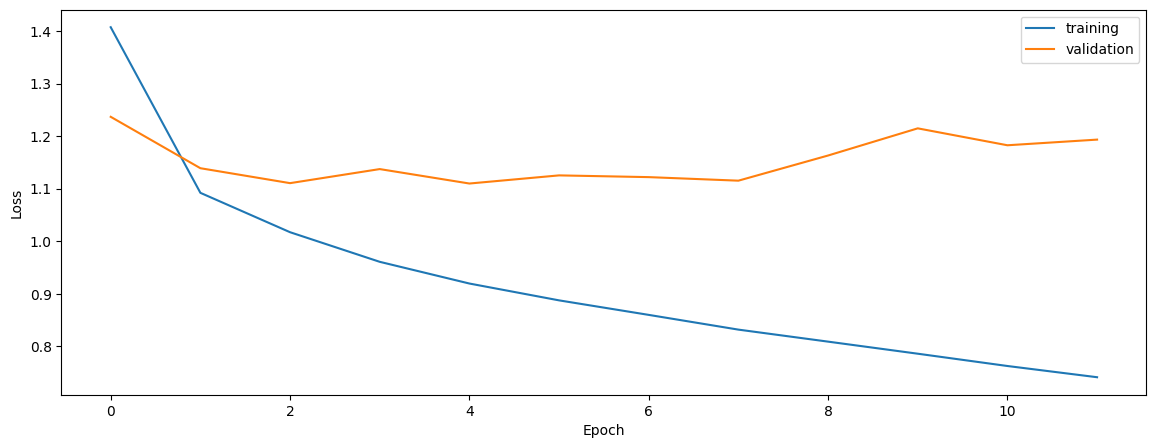

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6522174012666081
0.5567454581499238
0.5450176833355113


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6099858652213263
0.5416390159850046
0.5713531036138793


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6102674618687248
0.5495012234142669
0.579501721693336


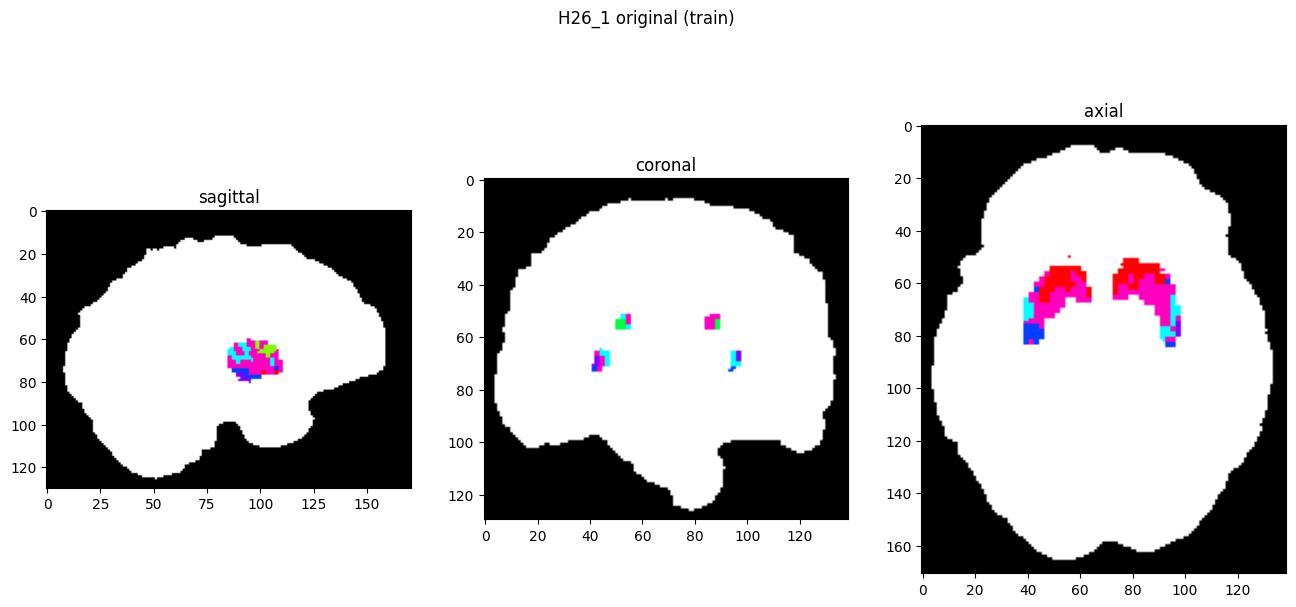

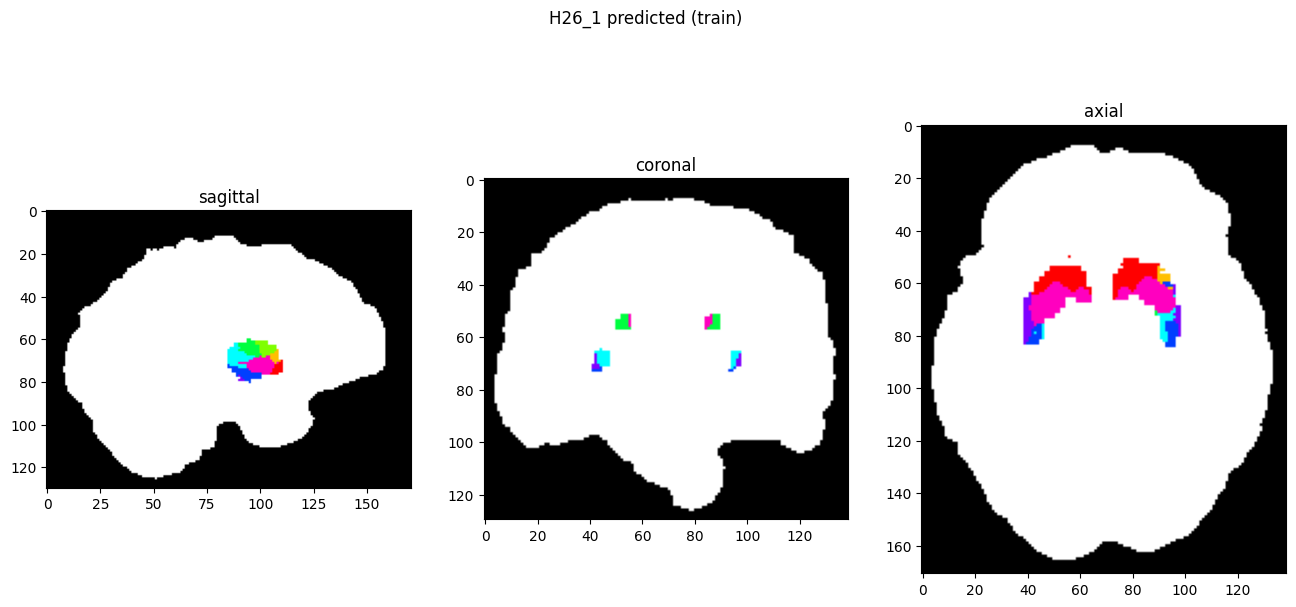

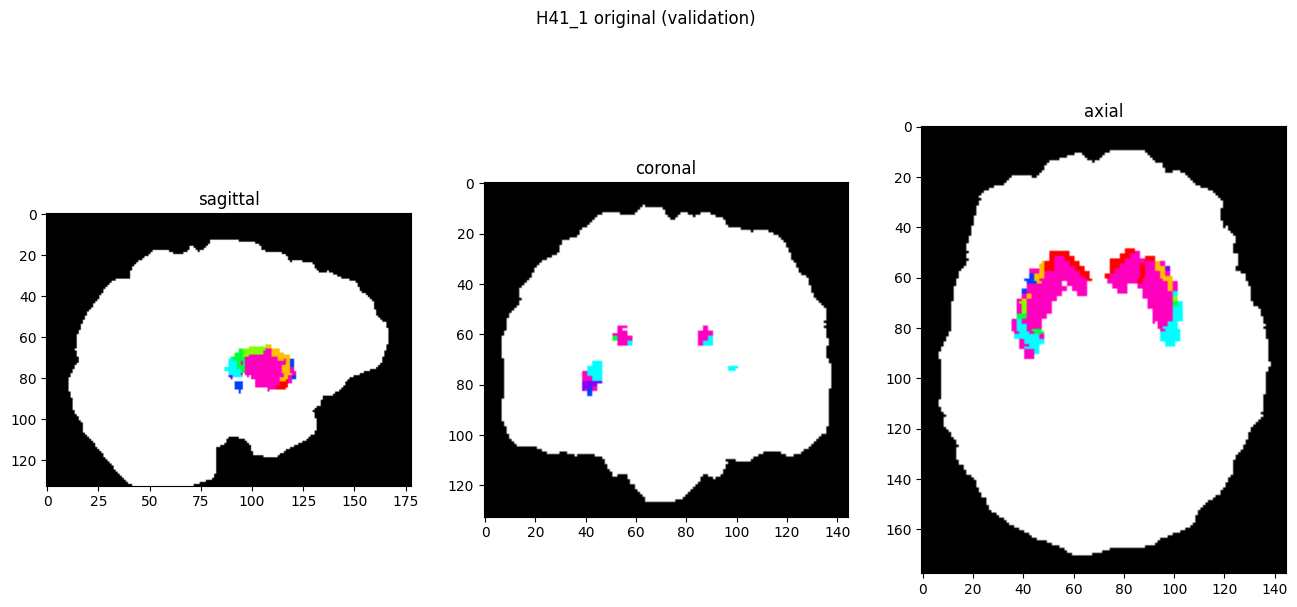

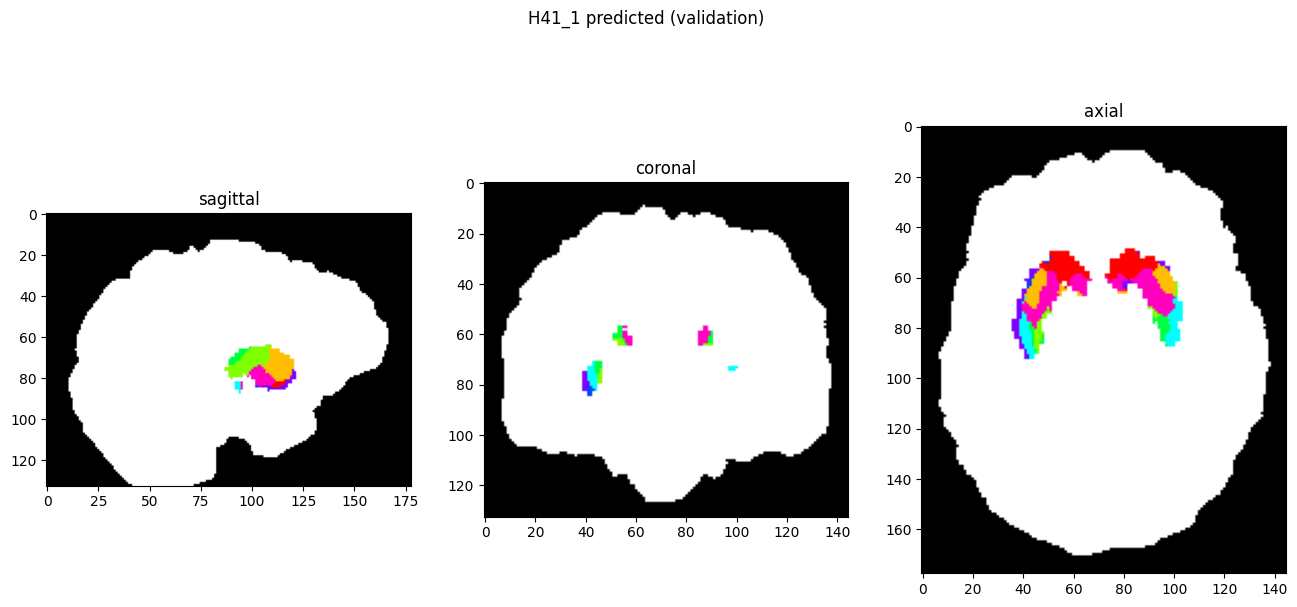

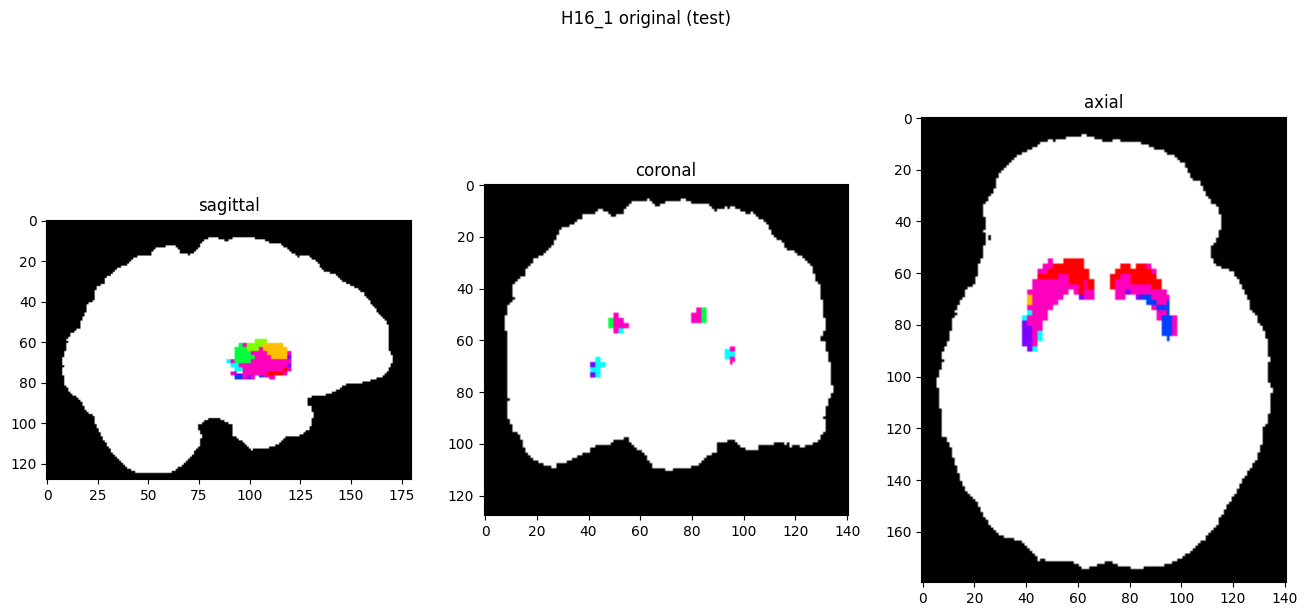

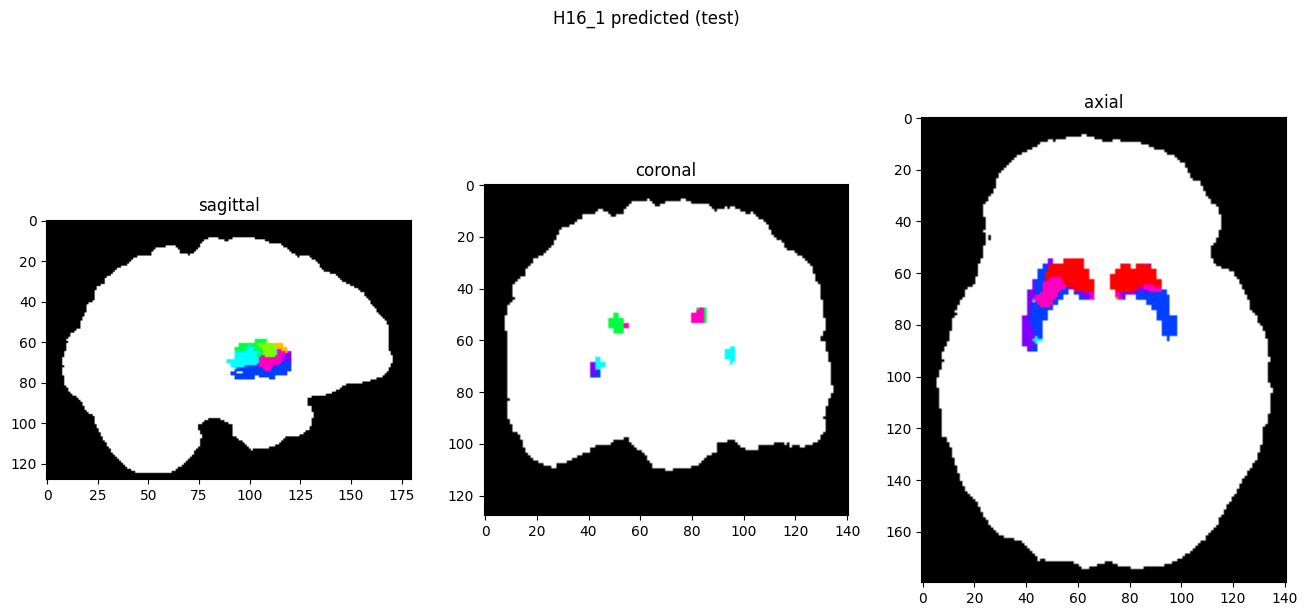

In [10]:
showResults(model, gen, threshold=0)